# Analysing Indian Media On Youtube.

* Idea is to pull the title and description of youtube videos for various Indian Media Outlets and perform text analytics on it
* Goal of doing the text analytics is to try and analyze the topics frequently discussed and figure out if outlets can be categorized.

* Not for me to draw conclusions, therefore I will just leave the data and charts *as is*

### Install Spacy
Spacy provides trained word to vector models that can be used for part of speech tagging / entity extraction etc. We will use it later in the analysis


In [0]:
!pip install spacy

In [0]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


## Text Preprocessing

NLTK provides various text analysis features including basic functionality like removing stopwords, tokenizing words etc.

Let's import the module below

In [0]:
import nltk
from nltk.corpus import stopwords

In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Adding "episode" to the set of stopwords because it appears quite a few times in the description of the youtube videos


In [0]:
stopwords_set = stopwords.words('english')
stopwords_set = set(stopwords_set).union(set(["episode"]))

### Import numpy and Pandas

In [0]:
import numpy as np
import pandas as pd

* Read the data in

In [0]:
df = pd.read_csv("text.csv")

In [0]:
df.head()

Channel Id  ...                                        Description
0       WIRE  ...  As of Monday morning, there were 415 total con...
1       WIRE  ...  Since yesterday, 99 new cases of COVID 19 have...
2       WIRE  ...  As of  Wednesday evening, there were 553 confi...
3       WIRE  ...  As of Thursday morning, there were 593 active ...
4       WIRE  ...  As of Friday morning, 724 people with COVID-19...

[5 rows x 5 columns]

### Data 


* Each row in the data represents one video
* data has 5 columns
1. **Channel Id** - Provides the Indian Media Channel Id that can be used to uniquely identify the outlet
2. **Playlist title** is the title of the playlist to which the video
3. **Date** - Date when the episode was published
4. **Title** - Title of the video
5. **Description** - Description of the video

### Lets see how many unique media outlets we have

In [0]:
df["Channel Id"].unique()

array(['WIRE', 'PRINT', 'INDIA_TODAY', 'REPUBLIC_WORLD'], dtype=object)

* Lets drop duplicate video information (if any)

In [0]:
df = df.drop_duplicates()

Lets check how many video information we have

In [0]:
df.shape

(14246, 5)

Lets drop video informations that have NA in them

In [0]:
df = df.dropna()

Let's combine the Title and description of each video to another field called 'text'. This will allow easier analysis.

In [0]:
df["text"] = df["Title"] + "\n" + df["Description"]

In [0]:
df["text"].head()

0    Coronavirus Updates, March 23: States Shut Bor...
1    Coronavirus Updates, March 24: Nation on Lockd...
2    Coronavirus Updates, March 25: Chaos in Supply...
3    Coronavirus Updates, March 26: Economic Relief...
4    Coronavirus Updates, March 27: Unprotected Med...
Name: text, dtype: object

In [0]:
# Lower the text
df["text"] = df["text"].str.lower()

### Text Processing

* To tokenize the sentences we can use the Regexp Tokenizer provided by NLTK

In [0]:
from nltk import RegexpTokenizer

Below variable 'promotion' includes text that is identified as advertisement or promotional, so that the tokens included in that variable can be excluded from further analysis. This will lead to loss of some information but more importantly will remove garbage from the text.

In [0]:
promotion = """
like our work?  click here to support the wire: https://thewire.in/support

the founding premise of the wire is this: if good journalism is to survive and thrive, it can only do so by being both editorially and financially independent. this means relying principally on contributions from readers and concerned citizens who have no interest other than to sustain a space for quality journalism. as a publication, the wire will be firmly committed to the public interest and democratic values.
we publish in four different languages!
for english, visit www.thewire.in
for hindi: http://thewirehindi.com/
for urdu: http://thewireurdu.com
for marathi: https://marathi.thewire.in
if you are a young writer or a creator, you can submit articles, essays, photos, poetry – anything that’s straight out of your imagination – to livewire, the wire’s portal for the young, by the young. https://livewire.thewire.in/
you can also follow the wire’s social media platforms and engage with us.
facebook
https://www.facebook.com/thewire/
https://www.facebook.com/thewirehindi/
https://www.facebook.com/thewireurdu/
https://www.facebook.com/thewiremarathi/
twitter
https://twitter.com/thewire_in
https://twitter.com/thewirehindi
https://twitter.com/thewireurdu
https://twitter.com/thewiremarathi
https://twitter.com/livewire
instagram
https://www.instagram.com/thewirein/
https://www.instagram.com/livewirein/
don’t forget to hit the subscribe button to never miss a video from the wire!
"""

In [0]:
tokenizer = nltk.RegexpTokenizer(r"\w{3,}")

In [0]:
promotion = set(tokenizer.tokenize(promotion))

After the above line now 'promotion' variable holds all tokens that we want to ignore.

### Document Vectors

* Now to continue with our processing of data we Import CountVectorizer and TfidfVectorizer.
* TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features.
  - This will allow us to form a basic vocobulary across media outlets
  - We don't want words/terms that are mostly/only used by one outlet to show up in our analysis because our analysis is mostly going to be comparitive. If words don't appear across channels then there won't be much to compare.
  - We can also use CountVectorizer to meet our above goal, as the only thing needed is the vocabulary.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

Let's create a function getVocab

This function takes as input a dataframe and then fits a CountVectorizer to the "text" column of the dataframe and returns the learned vocabulary as a set

In [0]:
def getVocab(df):
  vectorizer = CountVectorizer(min_df=5)
  vectorizer.fit(df["text"])
  return set(vectorizer.get_feature_names())

Now to get Vocabulary of each of the outlet we first group by the *channel id* and then apply our function *getVocab*

In [0]:
vocabs = df.groupby("Channel Id").apply(getVocab)

Now below we combine all the vocabularies by keeping the intersection only

In [0]:
final_vocab = CountVectorizer(min_df=2).fit([" ".join(list(v)) for v in vocabs]).get_feature_names()

In [0]:
len(final_vocab)

2585

As we see above the total number of words/tokens appearing across medial outlets are only around 1400.

Now let's move on to tokenizing *text* of each video.
The idea is to 
  - Remove the stop words
  - Remove words in promotion
  - Keep Only words that are in final_vocab

In [0]:
def tokenizeRows(sent):
  try:
    #print(sent)
    tokens = [w for w in tokenizer.tokenize(sent) if w not in stopwords_set and w not in promotion and w in final_vocab]
    return " ".join(tokens)
  except:
    return None

In [0]:
df["filtered_text"] = df["text"].apply(tokenizeRows)
df = df.dropna()

In [0]:
df.head()

Channel Id  ...                                      filtered_text
0       WIRE  ...  coronavirus updates march states shut tests po...
1       WIRE  ...  coronavirus updates march nation lockdown days...
2       WIRE  ...  coronavirus updates march chaos supply first d...
3       WIRE  ...  coronavirus updates march economic relief pack...
4       WIRE  ...  coronavirus updates march treat covid patients...

[5 rows x 7 columns]

As is seen above, the *filtered_text* column now containes trimmed down sentences which include only tokens of interest.

### Document Vectors

- Now finally we can convert each video text to a vector using the Tfidf Vectorizer.
- Few parameters that we use here are
  - *ngram_range* - this parameter can be used to create ngrams as well apart from just including single words.
  - *min_df* - we want the tokens to appear in atleast 10 videos for them to be considered part of the vocabulary
  - *max_df* - We want to remove tokens that appear in more than fraction of all videos

In [0]:
cvect = TfidfVectorizer(ngram_range=(1,1) , min_df=10 ,max_df=0.5)
allSentsCounts = cvect.fit_transform(df["filtered_text"])

In [0]:
allSentsCounts.shape

(14241, 2236)

We see above that number of features comes around 500. Everything is stored currently in a *Sparse Matrix* and hence not using much RAM

In [0]:
allSentsCounts[:2]

<2x2236 sparse matrix of type '<class 'numpy.float64'>'
	with 94 stored elements in Compressed Sparse Row format>

In [0]:
countdf = pd.DataFrame(allSentsCounts.toarray()  , columns=cvect.get_feature_names() , index=df.index)
countdf.head()

000      100       144  1971  1984  ...  रमण  वजह  सकत  सबस  सरक
0  0.000000  0.00000  0.129564   0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0
1  0.000000  0.11606  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0
2  0.000000  0.00000  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0
3  0.000000  0.00000  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0
4  0.096626  0.00000  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0  0.0

[5 rows x 2236 columns]

In [0]:
countdf["channel_id"] = df["Channel Id"]

In [0]:
countdf.iloc[: , :10].describe()

000           100  ...          2016          2018
count  14241.000000  14241.000000  ...  14241.000000  14241.000000
mean       0.004008      0.001576  ...      0.000466      0.009822
std        0.032231      0.021522  ...      0.012399      0.055979
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.000000  ...      0.000000      0.000000
50%        0.000000      0.000000  ...      0.000000      0.000000
75%        0.000000      0.000000  ...      0.000000      0.000000
max        1.000000      0.885818  ...      0.627118      0.696420

[8 rows x 10 columns]

### Word Cloud

* To create word cloud we will use the wordcloud package.
* The wordcloud package allows use to generate wordcloud from frequencies
* To count how many times each word appears across media outlets we melt the *countdf* and the group by *variable* and *sum* the *value* column
* After calculating the counts we sort the dataframe in descending order of *value*

In [0]:
wordCounts = pd.melt(countdf , id_vars="channel_id").groupby("variable").agg("sum").sort_values("value" , ascending=False)

In [0]:
wordCounts.head()

value
variable             
republic  1900.340498
today     1042.752837
live       762.299618
new        639.348905
videos     607.005280

Below we convert the dataframe of word counts into a dictionary format that is needed by the wordcloud package.

Format is {"worda" : "counta" , "wordb" : "countb"....}

In [0]:
#wctext = "\n".join(countdf.iloc[-400: -200, :]["word"].values)
#wctext = "\n".join(allSents)
wctext = wordCounts.reset_index().iloc[:200, :]
wcfreq = {}
for idx , row in wctext.iterrows():
  wcfreq[row["variable"]] = row["value"]

In [0]:
import wordcloud

In [0]:
wc = wordcloud.WordCloud().generate_from_frequencies(wcfreq)

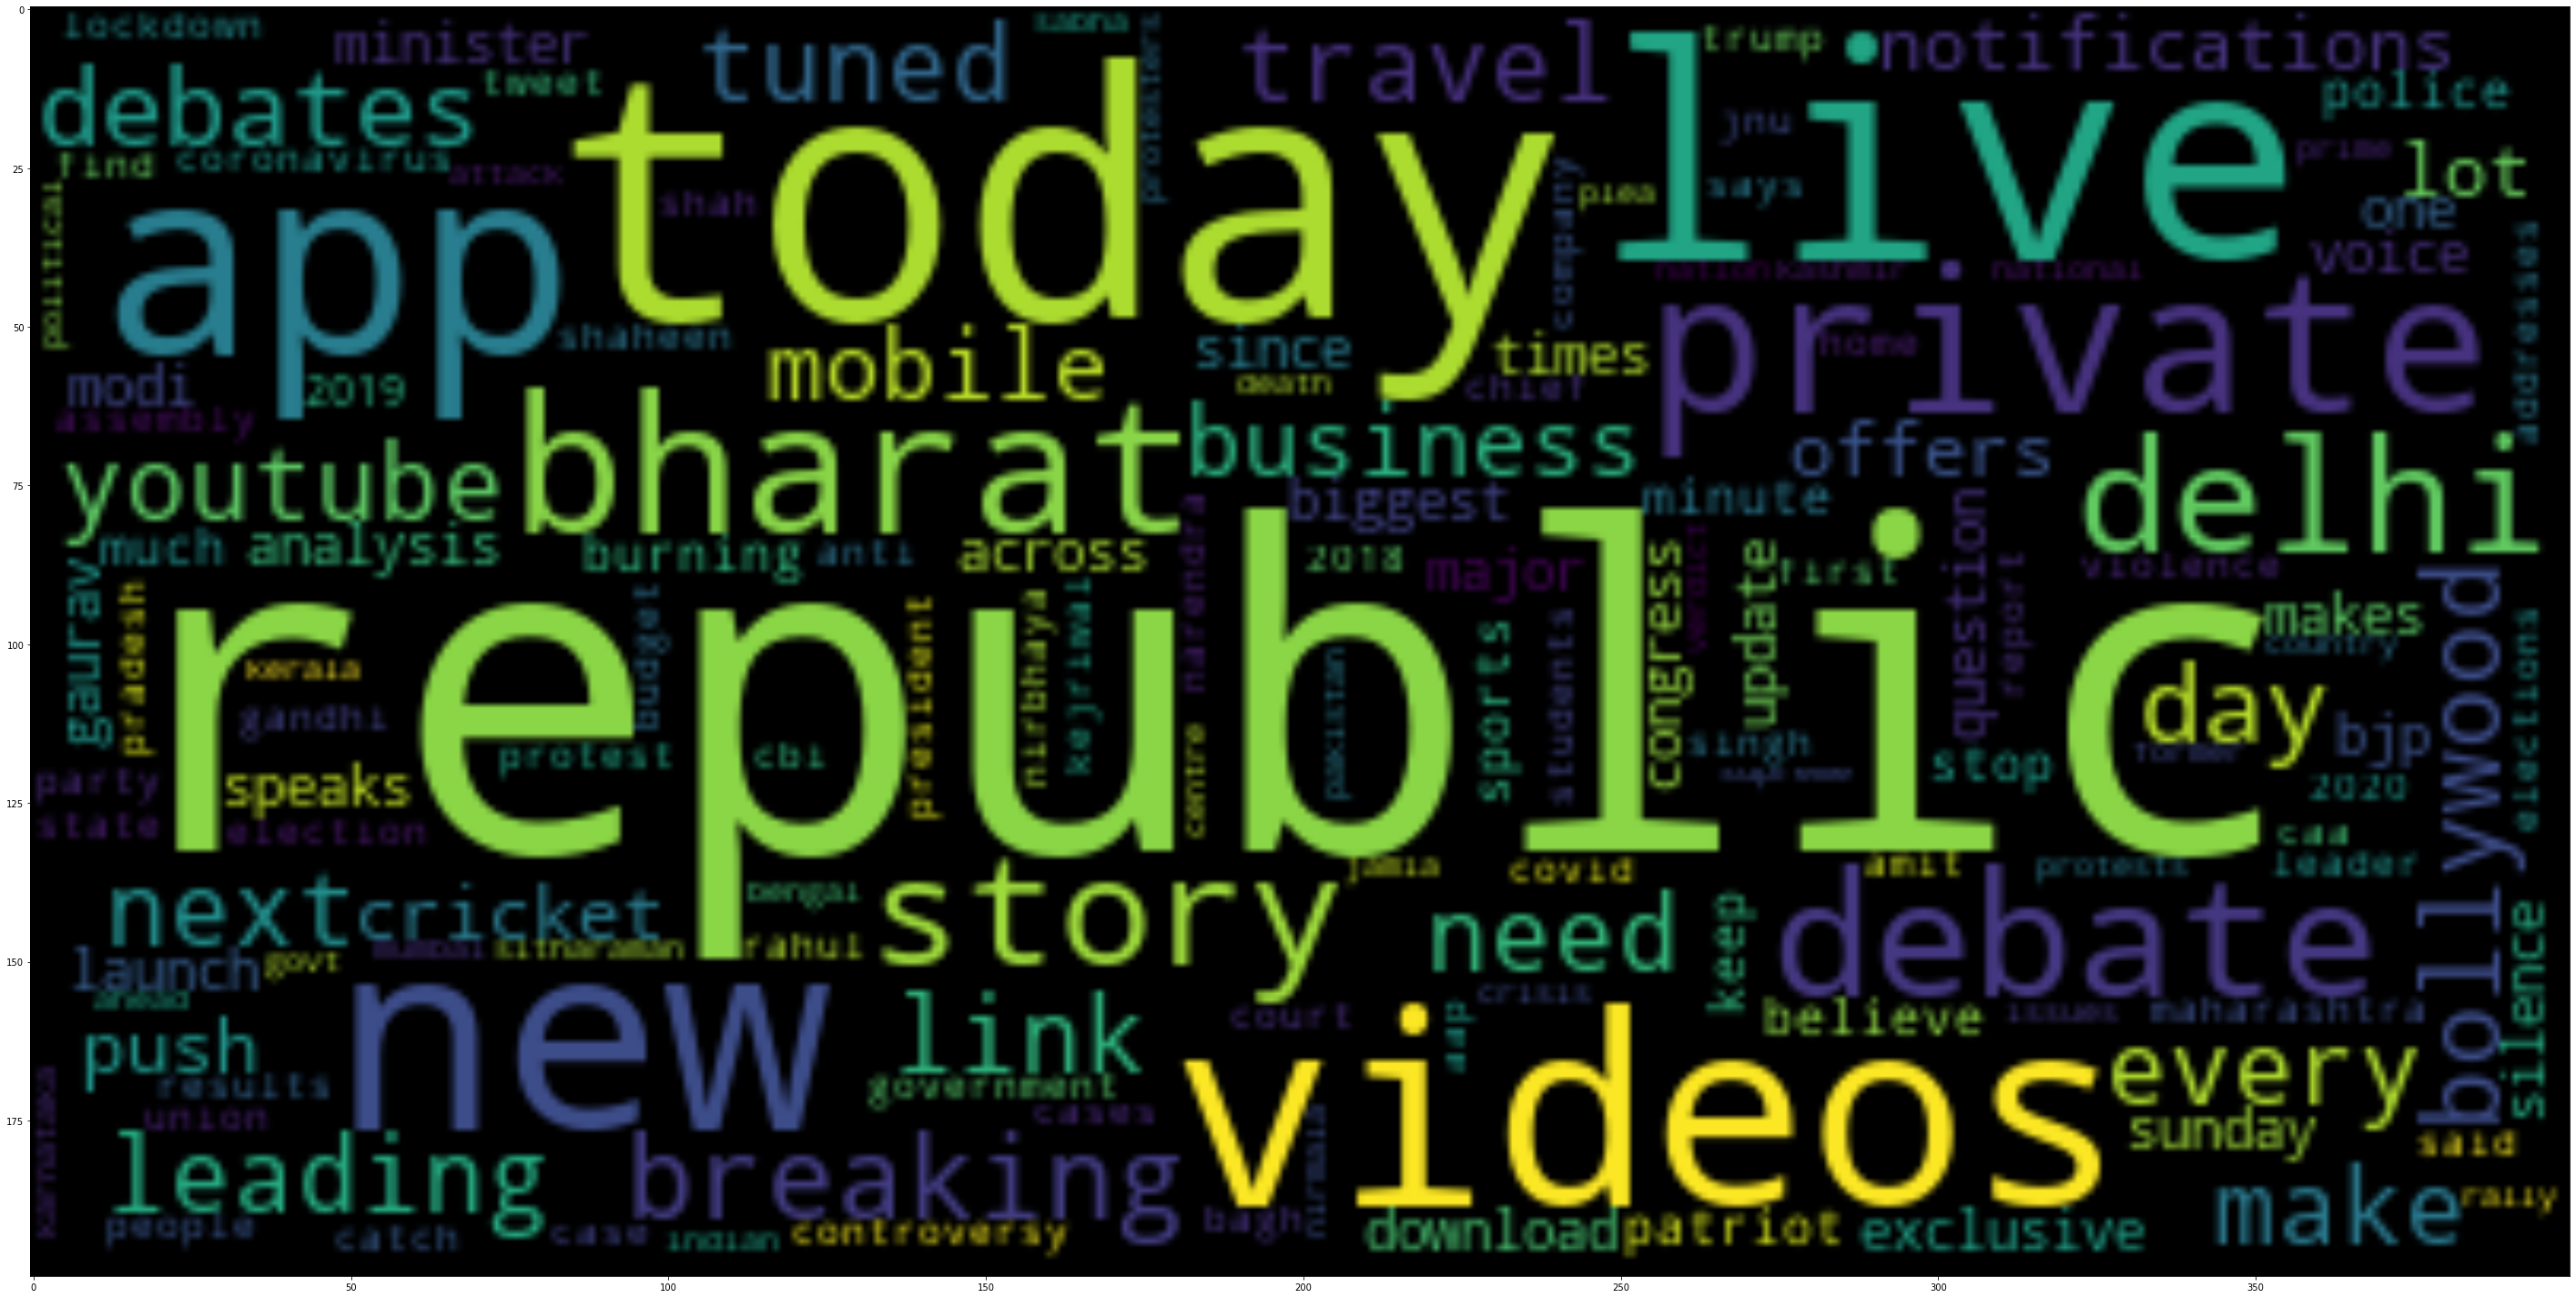

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(wc , interpolation='bilinear')

In [0]:
countdf.shape

(14241, 2237)

## Word / Term similarity

* Now that we have our counts lets try and figure out correlated terms
* Pandas provides a shortcut for calculating the correlation matrix with the *.corr()* method


In [0]:
wordCorrelations = countdf.corr()

In [42]:
wordCorrelations.shape

(2236, 2236)

In [43]:
wordCorrelations.head()

000       100       144  ...       सकत       सबस       सरक
000   1.000000  0.020208 -0.005458  ... -0.005595 -0.003823  0.033073
100   0.020208  1.000000 -0.003213  ... -0.003294 -0.002250  0.025649
144  -0.005458 -0.003213  1.000000  ... -0.001974 -0.001349  0.031341
1971 -0.003188 -0.001877 -0.001125  ... -0.001153 -0.000788 -0.001858
1984 -0.006077 -0.003578 -0.002145  ...  0.058545 -0.001502 -0.003541

[5 rows x 2236 columns]

Since all words are completely correlated with self, we replace 1 with np.NaN

In [0]:
wordCorrelations.index = pd.Index(cvect.get_feature_names())
wordCorrelations.columns = cvect.get_feature_names()
wordCorrelations[wordCorrelations == 1] = np.NaN

In [45]:
wordCorrelations.head()

000       100       144  ...       सकत       सबस       सरक
000        NaN  0.020208 -0.005458  ... -0.005595 -0.003823  0.033073
100   0.020208       NaN -0.003213  ... -0.003294 -0.002250  0.025649
144  -0.005458 -0.003213       NaN  ... -0.001974 -0.001349  0.031341
1971 -0.003188 -0.001877 -0.001125  ... -0.001153 -0.000788 -0.001858
1984 -0.006077 -0.003578 -0.002145  ...  0.058545 -0.001502 -0.003541

[5 rows x 2236 columns]

### Helper method

the *findSimilar* method below takes as input a word and an integer *n* specifiying how many similar terms it should return

* It finds most correlated terms and returns those as the similar terms

In [0]:
def findSimilar(term,n) :
  print(wordCorrelations[term].sort_values(ascending=False)[:n].index.values)

### Politics

In [47]:
for t in ["bjp" , "modi" , "congress", "rahul" , "aap" , "gandhi"]:
  print(t)
  findSimilar(t , 10)
  print("----")

bjp
['party' 'election' 'assembly' 'nadda' 'scindia' 'aap' 'jyotiraditya'
 'seats' 'decades' 'verma']
----
modi
['narendra' 'prime' 'event' 'mega' 'rally' 'stadium' 'bharat' 'addresses'
 'minister' 'trump']
----
congress
['mlas' 'gandhi' 'scindia' 'party' 'jyotiraditya' 'leader' 'resignation'
 'sonia' 'madhya' 'rebel']
----
rahul
['gandhi' 'congress' 'resignation' 'uproar' 'ideology' 'controversy'
 'paid' 'attack' 'president' 'questions']
----
aap
['aam' 'aadmi' 'party' 'decades' 'kejriwal' 'arvind' 'contest' 'delhi'
 'election' '2015']
----
gandhi
['rahul' 'priyanka' 'sonia' 'congress' 'mahatma' 'vadra' 'resignation'
 'manmohan' 'rajiv' 'president']
----


### Religion

In [48]:
for t in ["hindu" , "muslim" , "nrc" , "caa"]:
  print(t)
  findSimilar(t , 10)
  print("----")

hindu
['muslim' 'rush' 'clear' 'pakistani' 'call' 'terror' 'carried' 'kanpur'
 'dissent' 'gave']
----
muslim
['hindu' 'residents' 'carried' 'mob' 'nagar' 'aligarh' 'opinion' 'written'
 'caa' 'community']
----
nrc
['npr' 'caa' 'population' 'amitshah' 'citizenship' 'amendment' 'act'
 'national' 'reportedly' 'chennai']
----
caa
['anti' 'citizenship' 'act' 'nrc' 'protests' 'amendment' 'protesters'
 'protest' 'chennai' 'pro']
----


### Kashmir

In [49]:
for t in ["kashmir" , "370" , "terror"]:
  print(t)
  findSimilar(t , 10)
  print("----")

kashmir
['jammu' 'valley' '370' 'poster' 'terrorists' 'article' 'lie' 'free'
 'abrogation' 'hizbul']
----
370
['article' 'abrogation' 'kashmir' 'सबस' 'larger' 'rest' 'ladakh' 'jammu'
 'bench' 'constitutional']
----
terror
['pulwama' 'attack' 'anniversary' 'rush' 'pakistan' 'jaish' 'forces'
 'strike' 'hindu' 'nia']
----


### Coronavirus

In [50]:
for t in ["coronavirus" , "death" , "health"]:
  print(t)
  findSimilar(t , 10)
  print("----")

coronavirus
['outbreak' 'positive' 'covid' 'pandemic' 'cases' 'novel' 'virus' 'health'
 'spread' 'deadly']
----
death
['toll' 'rises' 'warrant' 'penalty' 'nirbhaya' 'convicts' 'infant' 'kota'
 'sentence' 'hospital']
----
health
['heart' 'ministry' 'coronavirus' 'covid' 'vardhan' 'cases' 'jain' 'harsh'
 'emergency' 'organization']
----


### Indian Neighbors

In [51]:
for t in ["chinese" , "indian",  "pakistan" ]:
  print(t)
  findSimilar(t , 10)
  print("----")

chinese
['china' 'studies' 'kits' 'dissent' 'ladakh' 'believed' 'epicentre'
 'institute' 'soldiers' 'wuhan']
----
indian
['army' 'economy' 'railways' 'navy' 'forces' '71st' 'loc' 'force'
 'indians' 'pakistan']
----
pakistan
['nankana' 'sahib' 'loc' 'sikh' 'pak' 'gurudwara' 'army' 'along' 'imran'
 'terror']
----


### Economy

In [52]:
for t in ["economy" , "growth" , "budget" , "tax" , "gdp" , "finance"]:
  print(t)
  findSimilar(t , 10)
  print("----")

economy
['revive' 'economic' 'growth' 'indian' 'economist' 'stimulus' 'package'
 'target' 'activity' 'gdp']
----
growth
['gdp' 'fiscal' 'revive' 'budget' 'economic' 'budget2020' 'expected'
 'economy' 'map' 'second']
----
budget
['budget2020' 'sitharaman' 'nirmala' '2020' 'finance' 'presented'
 'session' 'growth' 'second' 'expected']
----
tax
['income' 'sitharaman' 'rates' 'reforms' 'nirmala' 'reduced' 'budget2020'
 'budget' 'presented' 'finance']
----
gdp
['growth' 'september' 'economy' 'chidambaram' 'chandra' 'subhash' 'low'
 'mean' 'fiscal' 'maha']
----
finance
['nirmala' 'sitharaman' 'minister' 'budget' 'package' 'stimulus'
 'announced' 'measures' 'crore' 'second']
----


### Armed Forces

In [53]:
for t in ["defence" , "army" , "military" ]:
  print(t)
  findSimilar(t , 10)
  print("----")

defence
['cds' 'staff' 'rajnath' 'rawat' 'bipin' 'military' '71st' 'memorial'
 'celebrating' 'matters']
----
army
['indian' 'naravane' 'bipin' 'rawat' 'loc' 'jantar' 'mantar' 'pakistan'
 'chief' 'staff']
----
military
['american' 'targeting' 'iran' 'cds' '71st' 'coalition' 'matters'
 'celebrating' 'might' 'launched']
----


### Industry

In [54]:
for t in ["labour" , "industries" , "supply" ]:
  print(t)
  findSimilar(t , 10)
  print("----")

labour
['laws' 'low' 'industries' 'concern' 'organisation' 'supply'
 'international' 'basic' 'pratap' 'months']
----
industries
['ppes' 'preparing' 'zones' 'low' 'frontline' 'labour' '3rd' 'final'
 'activities' 'deol']
----
supply
['chain' 'shortage' 'months' 'goods' 'prices' 'low' 'assess' 'worry'
 'measures' 'essential']
----


# Entity Analysis

Having seen what terms occur frequently together above, it's try to do some semantic analysis and extract various entities that the channels talk about.

* We should be able to look at the locations, languages, communities, people etc that are most mentioned

* In this section we will use the *text* field because *Spacy* uses entire sentences to give out the entities.

In [55]:
df["text"].head()

0    coronavirus updates, march 23: states shut bor...
1    coronavirus updates, march 24: nation on lockd...
2    coronavirus updates, march 25: chaos in supply...
3    coronavirus updates, march 26: economic relief...
4    coronavirus updates, march 27: unprotected med...
Name: text, dtype: object

In [0]:
nlp = spacy.load("en_core_web_md")

In [0]:
gpd = lambda r: (r.name,nlp(r["text"]))

In [0]:
parsed_docs = df.apply(gpd , axis=1)

In [59]:
parsed_docs

0        (0, (coronavirus, updates, ,, march, 23, :, st...
1        (1, (coronavirus, updates, ,, march, 24, :, na...
2        (2, (coronavirus, updates, ,, march, 25, :, ch...
3        (3, (coronavirus, updates, ,, march, 26, :, ec...
4        (4, (coronavirus, updates, ,, march, 27, :, un...
                               ...                        
15149    (15149, (harsimrat, kaur, badal, speaks, to, m...
15150    (15150, (harsimrat, kaur, badal, 's, scathing,...
15151    (15151, (ravneet, singh, bittu, ,, sambit, pat...
15153    (15153, (hs, phoolka, speaks, to, republic, tv...
15154    (15154, (hs, phoolka, challenges, rahul, gandh...
Length: 14241, dtype: object

In [0]:
entity_df = pd.DataFrame([(ent.text , ent.label_ , df.loc[i]["Channel Id"]) for i,doc in parsed_docs for ent in doc.ents],\
                         columns=["text" , "label" , "channel"])

In [61]:
entity_df.head()

text     label channel
0          march 23      DATE    WIRE
1  harvey weinstein    PERSON    WIRE
2            monday      DATE    WIRE
3           morning      TIME    WIRE
4               415  CARDINAL    WIRE

In [62]:
label_prop_df = entity_df.groupby("channel")["label"].value_counts(normalize=True).reset_index(name="proportion")
label_prop_df.head()

channel     label  proportion
0  INDIA_TODAY       GPE    0.436284
1  INDIA_TODAY       ORG    0.192309
2  INDIA_TODAY    PERSON    0.135715
3  INDIA_TODAY  CARDINAL    0.077815
4  INDIA_TODAY      NORP    0.065381

In [0]:
from plotnine import *

### Defining a custom Theme

* Like in R with ggplot you can define your own custom theme to give more life to the plot
* let's define a theme with dark background and smoother contrasting colors

In [0]:
bgcolor = "#293241"
colors = ["#d88c9a","#f2d0a9" , "#f1e3d3" , "#99c1b9" , "#8e7dbe"]
mt = theme(panel_background=element_rect(fill=bgcolor) 
           ,plot_background=element_rect(fill=bgcolor)
           , axis_text_x = element_text(color="white")
           , axis_text_y = element_text(color="white"))


cat_colors = scale_fill_manual(values = colors)
cat_colors_lines = scale_color_manual(values = colors)

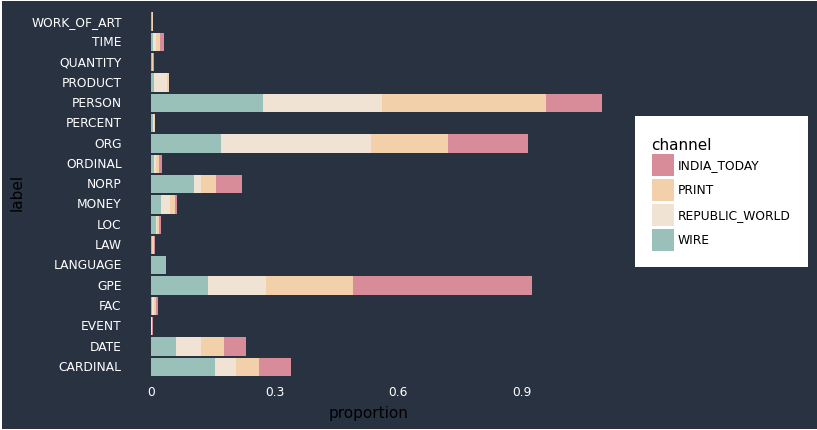

<ggplot: (8754720814877)>

In [68]:
ggplot(label_prop_df,  aes(x="label" , y="proportion" , fill="channel")) \
 + geom_col() \
 + coord_flip() \
 + cat_colors \
 + mt \
 + theme(panel_grid_minor=element_blank() , panel_grid_major=element_blank())

As can be seen above, as expected, channels mostly talk about People,Organizations Locations, Dates and Numbers. 

Below, let's try to see within each category how each channel fares.

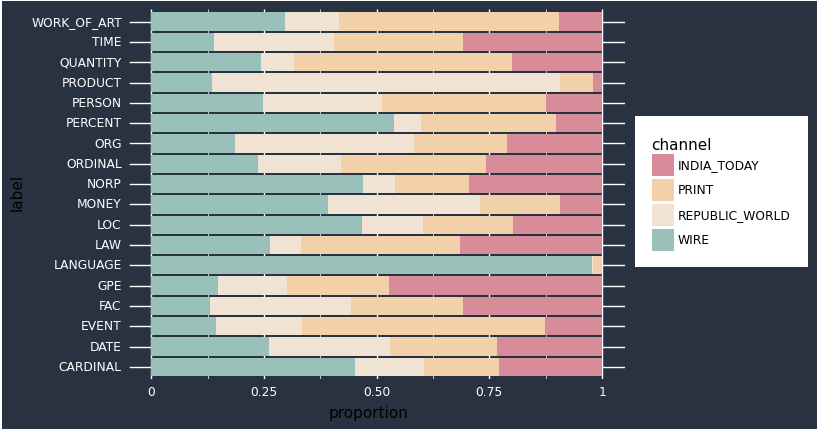

<ggplot: (8754720797395)>

In [69]:
ggplot(label_prop_df,  aes(x="label" , y="proportion" , fill="channel")) \
 + geom_col(position="fill") \
 + coord_flip() \
 + cat_colors \
 + mt

### Entity Counts

* Let's try and analyse how often each *entity* is mentioned within a channel and then compare these proportions
* For example let's say Modi is talked about in half of A's videos and only in 10 % percent of B's Videos , similary we can extend the analysis to different categories of labels as well.

In [0]:
entity_count_df = entity_df.groupby(["channel" , "label" ])["text"].value_counts(normalize=True).reset_index(name="counts")

* Lets convert counts to proportions

In [0]:
#entity_count_df["counts"] = entity_count_df.groupby("channel").apply(lambda df:df["counts"]/df["counts"].sum()).reset_index(drop=True)

In [72]:
entity_count_df

channel        label                        text    counts
0      INDIA_TODAY     CARDINAL  https://www.indiatoday.in/  0.425688
1      INDIA_TODAY     CARDINAL                         two  0.030065
2      INDIA_TODAY     CARDINAL                        2020  0.027515
3      INDIA_TODAY     CARDINAL                         one  0.027090
4      INDIA_TODAY     CARDINAL                        four  0.023372
...            ...          ...                         ...       ...
20208         WIRE  WORK_OF_ART           what ails the ias  0.066667
20209         WIRE  WORK_OF_ART                      yeh un  0.066667
20210         WIRE  WORK_OF_ART                   | kashmir  0.066667
20211         WIRE  WORK_OF_ART                        टेरर  0.066667
20212         WIRE  WORK_OF_ART                       सामना  0.066667

[20213 rows x 4 columns]

## Analysing People 

In [0]:
person_prop = entity_count_df[(entity_count_df["label"] == "PERSON")]

In [0]:
people_talked_on_almost_all = person_prop.groupby("text")["channel"]\
                                         .count()\
                                         .reset_index(name="counts")\
                                         .sort_values("counts" , ascending=False)


In [75]:
people_talked_on_almost_all

text  counts
3894          pm modi       4
203       aishe ghosh       4
3764    p chidambaram       4
1833   gautam gambhir       4
4940        shiv sena       4
...               ...     ...
2280             itbp       1
2279         it.catch       1
2278             isst       1
2277        ismat ara       1
6407  ₹5.95 lac worth       1

[6408 rows x 2 columns]

In [0]:
people_talked_on_almost_all = people_talked_on_almost_all[people_talked_on_almost_all["counts"] > 2]

In [77]:
people_talked_on_almost_all.shape

(178, 2)

In [78]:
people_talked_on_almost_all["text"].values

array(['pm modi', 'aishe ghosh', 'p chidambaram', 'gautam gambhir',
       'shiv sena', 'mamata banerjee', 'shaheen bagh', 'mohan bhagwat',
       'rahul gandhi', "rahul gandhi's", 'umar khalid', 'gandhi',
       'jyotiraditya scindia', 'nirmala sitharaman', 'covid',
       'chidambaram', "nirmala sitharaman's", 'mps', 'hemant soren',
       'amit shah', 'cm', 'the shiv sena', 'jharkhand', "narendra modi's",
       'the lok sabha', "amit shah's", 'narendra modi', 'vardhan',
       'mamata', 'arvind kejriwal', 'mlas', 'lok sabha', 'singh',
       'sitharaman', 'donald trump', 'yogi adityanath', 'modi-shah',
       'savarkar', 'modi', 'murli manohar joshi', 'bihar', 'jds', 'bjp',
       'sonia gandhi', 'dilip ghosh', 'mayawati', 'ramesh pokhriyal',
       'taj mahal', 'amarinder singh', 'niti aayog', 'naxal',
       'smriti irani', 'ajit doval', 'riyaz naikoo', 'isis',
       'digvijaya singh', 'deepender hooda', 'deepika padukone',
       "deepika padukone's", 'amit shah\n', 'nitin gadk

In [0]:
person_prop = person_prop[person_prop["text"].isin(people_talked_on_almost_all["text"])]

In [80]:
person_prop.shape

(578, 4)

In [81]:
person_prop

channel   label               text    counts
5314   INDIA_TODAY  PERSON                bjp  0.065725
5315   INDIA_TODAY  PERSON       shaheen bagh  0.040811
5317   INDIA_TODAY  PERSON          amit shah  0.019005
5318   INDIA_TODAY  PERSON      narendra modi  0.018456
5319   INDIA_TODAY  PERSON       donald trump  0.016751
...            ...     ...                ...       ...
19739         WIRE  PERSON            vardhan  0.000381
19748         WIRE  PERSON         xi jinping  0.000381
19751         WIRE  PERSON     yashwant sinha  0.000381
19755         WIRE  PERSON     yogendra yadav  0.000381
19756         WIRE  PERSON  yogi adityanath's  0.000381

[578 rows x 4 columns]

In [0]:
import warnings
warnings.filterwarnings('ignore')

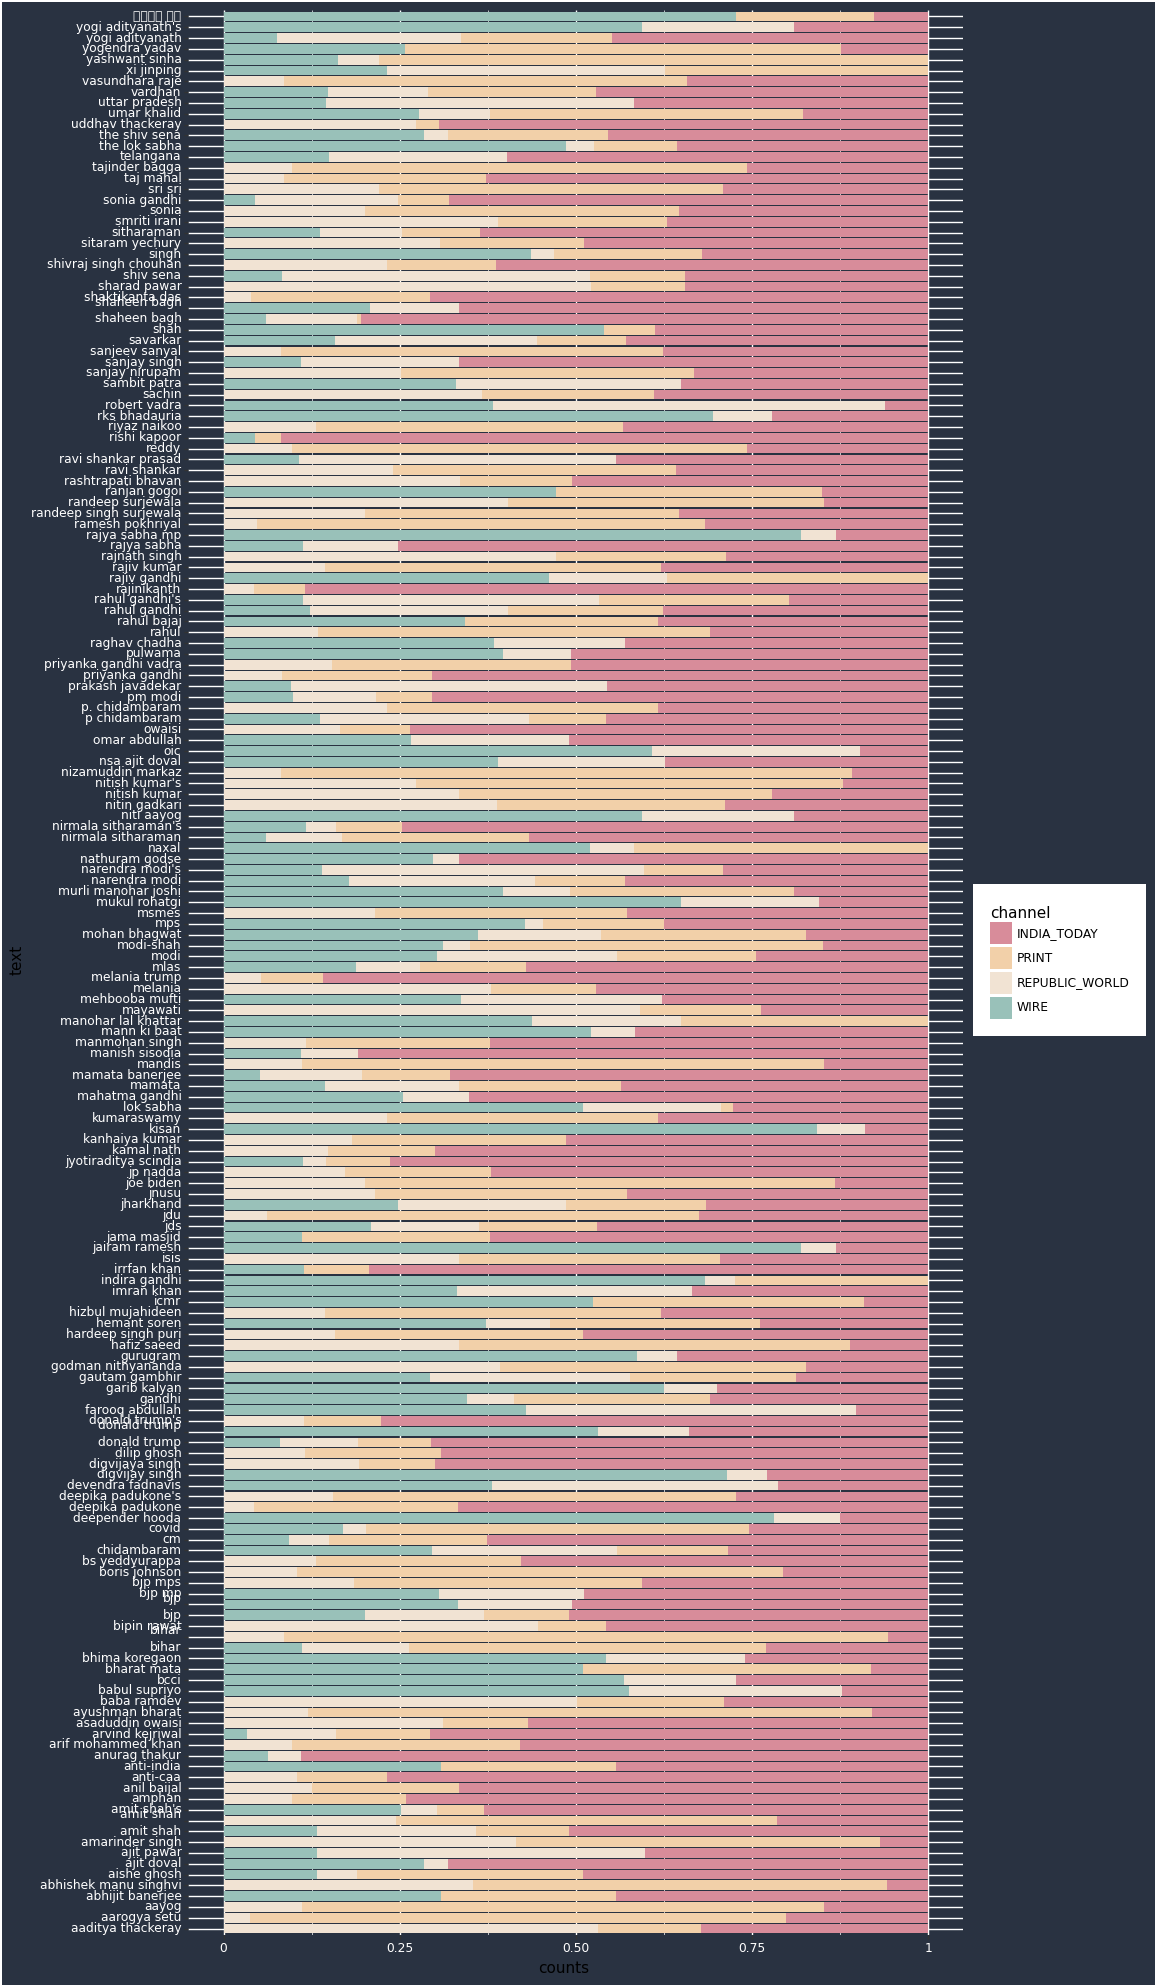

<ggplot: (-9223363282136695271)>

In [83]:
ggplot(person_prop , aes(x="text" , y="counts" , fill="channel")) \
+ geom_col(position="fill")\
+ coord_flip() \
+ cat_colors \
+ mt\
+ theme(figure_size=(10,25)) 

In [0]:
def plotChannelText(df ,figure_size=(2,2)):
  p = ggplot(df , aes(x="text" , y="counts" , fill="channel")) \
  + geom_col(position="fill")\
  + coord_flip() \
  + cat_colors \
  + mt\
  + theme(figure_size=figure_size) 
  print(p)

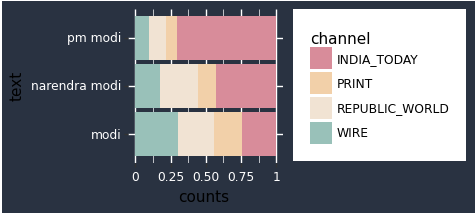

<ggplot: (-9223363282136841756)>


In [85]:
plot_person = person_prop[person_prop.text.isin(["pm modi" , "narendra modi" , "modi"])]
plotChannelText(plot_person)

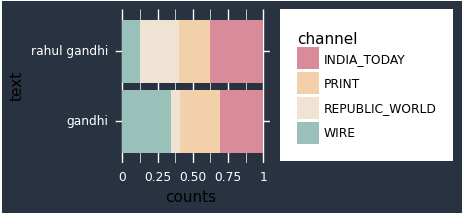

<ggplot: (-9223363282136653459)>


In [86]:
plot_person = person_prop[person_prop.text.isin(["gandhi" , "rahul gandhi" ])]
plotChannelText(plot_person)

## Location Analysis

In [0]:
def popularInLabel(label):
  person_prop = entity_count_df[(entity_count_df["label"] == label)]
  people_talked_on_almost_all = person_prop.groupby("text")["channel"]\
                                         .count()\
                                         .reset_index(name="counts")\
                                         .sort_values("counts" , ascending=False)
  people_talked_on_almost_all = people_talked_on_almost_all[people_talked_on_almost_all["counts"] > 2]
  person_prop = person_prop[person_prop["text"].isin(people_talked_on_almost_all["text"])]
  return person_prop


In [88]:
plot_df = popularInLabel("GPE")
plot_df.head()

channel label         text    counts
1885  INDIA_TODAY   GPE        india  0.714378
1886  INDIA_TODAY   GPE    bollywood  0.109406
1887  INDIA_TODAY   GPE        delhi  0.054286
1888  INDIA_TODAY   GPE  maharashtra  0.007068
1889  INDIA_TODAY   GPE       mumbai  0.006025

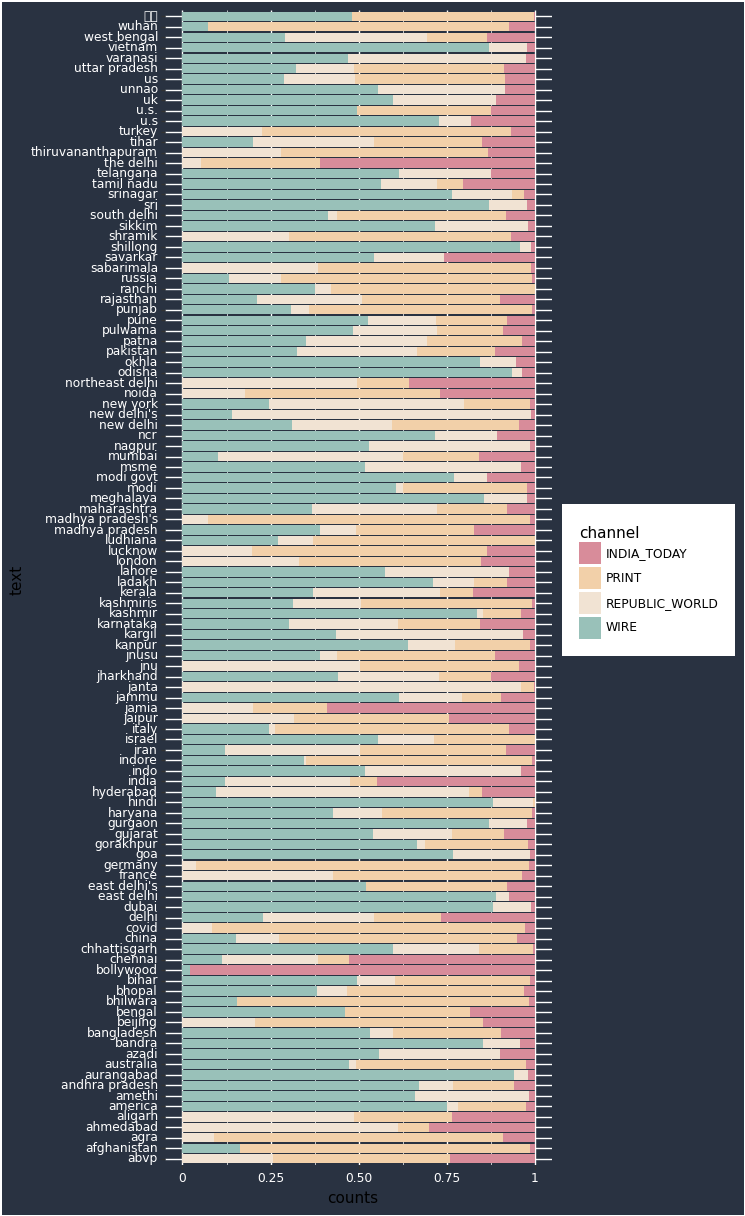

<ggplot: (8754718086320)>


In [89]:
plotChannelText(plot_df, (5,15))

### Kashmir

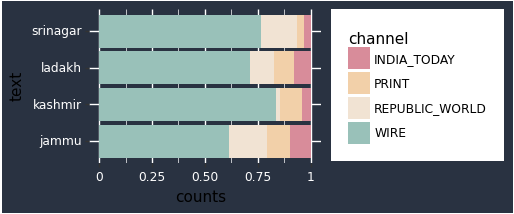

<ggplot: (-9223363282136836173)>


In [90]:
sub_plot_df = plot_df[plot_df["text"].isin(["kashmir" , "srinagar" , "jammu" , "ladakh"])]
plotChannelText(sub_plot_df , (3,2))

### International

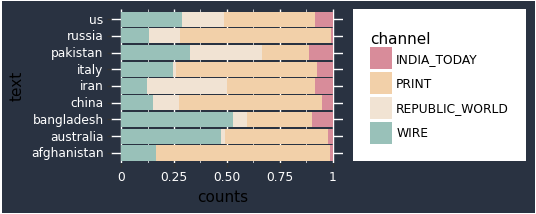

<ggplot: (-9223363282136963612)>


In [91]:
sub_plot_df = plot_df[plot_df["text"].isin(["afghanistan" ,"bangladesh" ,"srilanka" , "pakistan","us" , "iran" , "italy" , "china" ,"australia" , "russia"])]
plotChannelText(sub_plot_df , (3,2))

### Metros

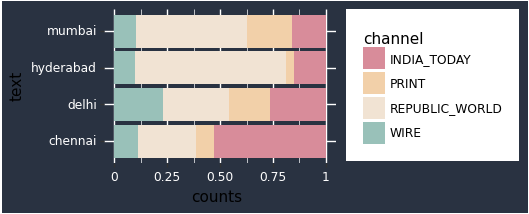

<ggplot: (-9223363282137052174)>


In [92]:
sub_plot_df = plot_df[plot_df["text"].isin(["delhi" , "mumbai" , "chennai" , "kolkata" , "hyderabad" ,"bangalore"])]
plotChannelText(sub_plot_df , (3,2))

### States


In [0]:
indian_states_list = [t.lower() for t in open("indian_states_list.txt").read().split("\n")]

In [94]:
indian_states_list[:5]

['andhra pradesh', 'arunachal pradesh', 'assam', 'bihar', 'chhattisgarh']

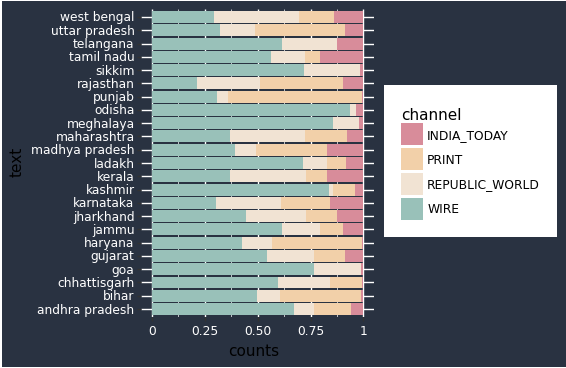

<ggplot: (8754717848591)>


In [95]:
sub_plot_df = plot_df[plot_df["text"].isin(indian_states_list)]
plotChannelText(sub_plot_df , (3,4))

### Cities

In [0]:
geo_list = [t.lower() for t in open("indian_cities_list.txt").read().split("\n")]

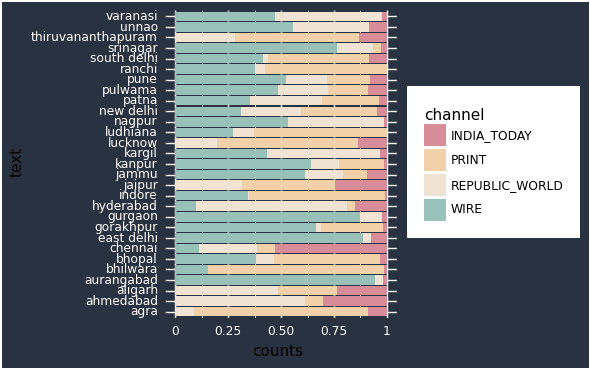

<ggplot: (8754717918847)>


In [97]:
sub_plot_df = plot_df[plot_df["text"].isin(geo_list)]
plotChannelText(sub_plot_df , (3,4))

## Organization

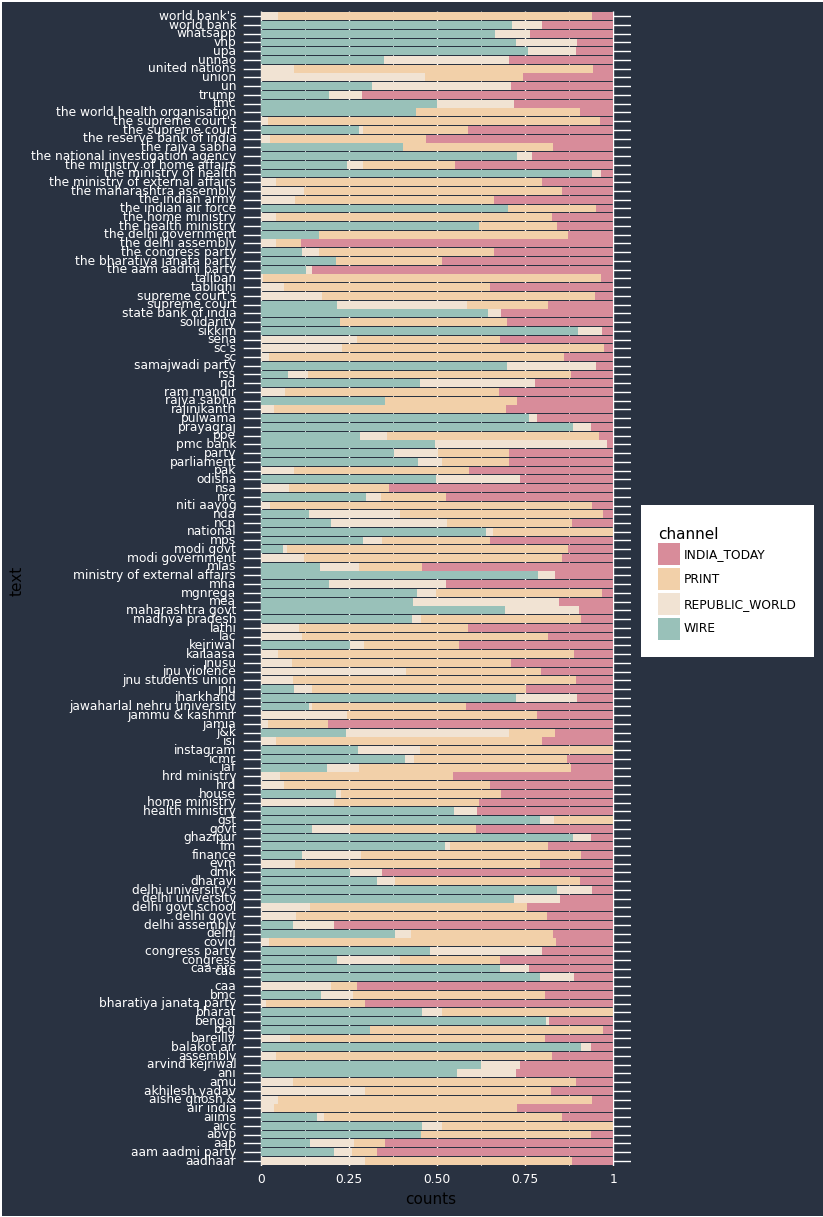

<ggplot: (-9223363282136903869)>


In [98]:
plot_df = popularInLabel("ORG")
plotChannelText(plot_df , (5,15))

### Political Parties

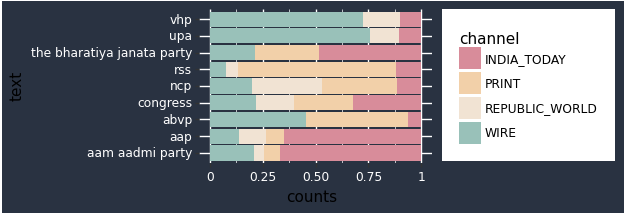

<ggplot: (-9223363282136903869)>


In [99]:
sub_plot_df = plot_df[plot_df["text"].isin(["aam aadmi party" ,"vhp","upa", "aap" , "ncp","congress","bjp" , "the bharatiya janata party" , "rss" , "abvp"])]
plotChannelText(sub_plot_df , (3,2))

### Government

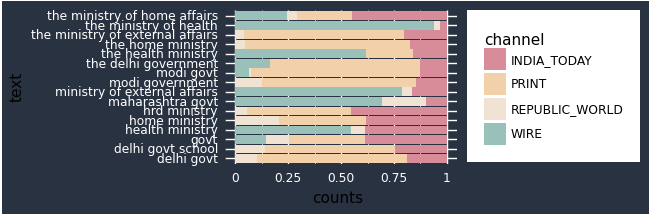

<ggplot: (-9223363282137165852)>


In [100]:
sub_plot_df = plot_df[plot_df["text"].str.match(".*(ministry|gov).*")]
plotChannelText(sub_plot_df , (3,2))

# Analysis of variations with Time

In [0]:
countdf["date"] = pd.to_datetime(df["Date"])
countdf["date"] = countdf["date"].dt.strftime("%m_%d_%y")

In [0]:
#countdf = countdf.drop(["Date"] , axis=1)#,"date_month",	"date_week",	"date_only" ] , axis=1)

In [107]:
countdf.head()

000      100       144  1971  1984  ...  वजह  सकत  सबस  सरक  channel_id
0  0.000000  0.00000  0.129564   0.0   0.0  ...  0.0  0.0  0.0  0.0        WIRE
1  0.000000  0.11606  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0        WIRE
2  0.000000  0.00000  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0        WIRE
3  0.000000  0.00000  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0        WIRE
4  0.096626  0.00000  0.000000   0.0   0.0  ...  0.0  0.0  0.0  0.0        WIRE

[5 rows x 2237 columns]

In [130]:
countdf.shape

(14241, 2239)

In [0]:
word_by_date = pd.melt(countdf , id_vars=["channel_id" , "date"])

### Every term by date data frame

* In this data frame now we have the proportions by channel for every day

In [109]:
word_by_date.head()

channel_id      date variable     value
0       WIRE  03_23_20      000  0.000000
1       WIRE  03_24_20      000  0.000000
2       WIRE  03_25_20      000  0.000000
3       WIRE  03_26_20      000  0.000000
4       WIRE  03_27_20      000  0.096626

In [0]:
word_by_date["date"] = pd.to_datetime(word_by_date["date"] , format="%m_%d_%y")
word_by_date["date_month"] = word_by_date["date"].dt.month
word_by_date["date_week"] = word_by_date["date"].dt.week

In [116]:
word_by_date.head()

channel_id       date variable     value  date_month  date_week
0       WIRE 2020-03-23      000  0.000000           3         13
1       WIRE 2020-03-24      000  0.000000           3         13
2       WIRE 2020-03-25      000  0.000000           3         13
3       WIRE 2020-03-26      000  0.000000           3         13
4       WIRE 2020-03-27      000  0.096626           3         13

In [129]:
word_by_date.shape

(31828635, 6)

### Term By Date - Rolling window

* Now we take the proportions and create a weekly rolling window of mean values that will give us better picture of how topic change with time for different news outlets

In [0]:
def termByDate(term , df):
  term_by_date = word_by_date[word_by_date["variable"] == term] 
  term_by_date["rolling"] = term_by_date.groupby("channel_id")["value"].transform(lambda x : x.rolling(7,1).mean())
  p = ggplot(term_by_date , aes(x="date" , y="rolling" , color="channel_id"  ,group="channel_id")) \
      + geom_line(size=5) \
      + cat_colors_lines \
      + mt \
      + theme(figure_size=(20,5) , panel_grid_major=element_blank() , panel_grid_minor=element_blank() , )
  
  print(p)

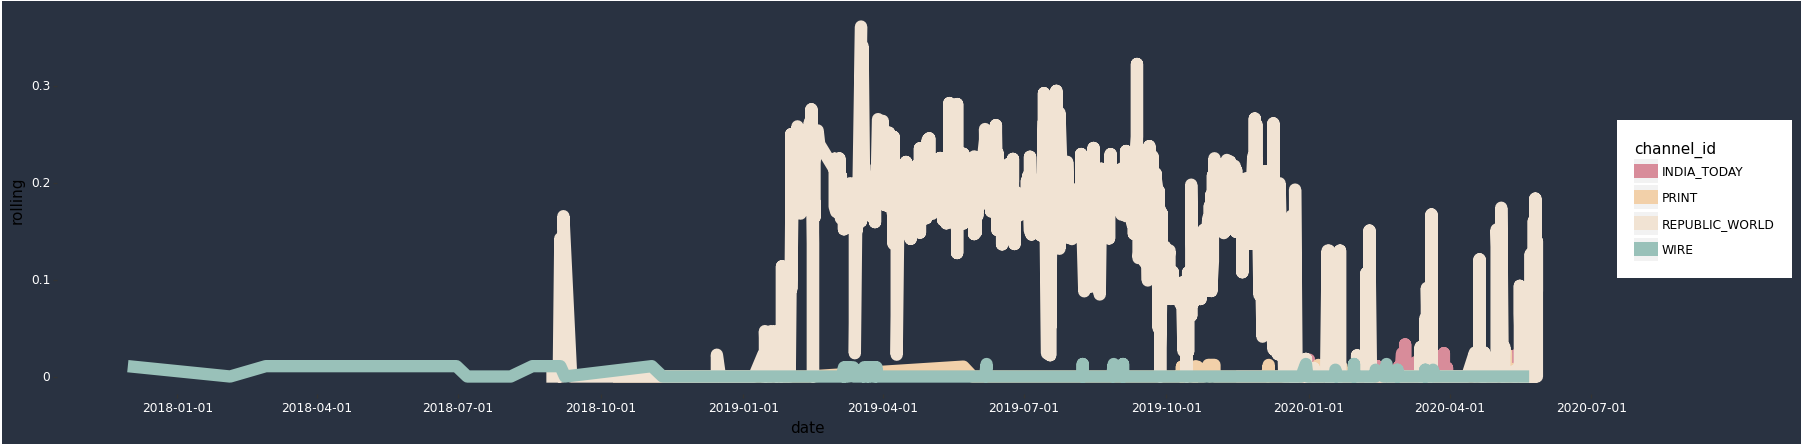

<ggplot: (-9223363282138614072)>


In [176]:
termByDate("bharat" , word_by_date)

* NOTE - Balakot air strike took place on 26 feb 2019

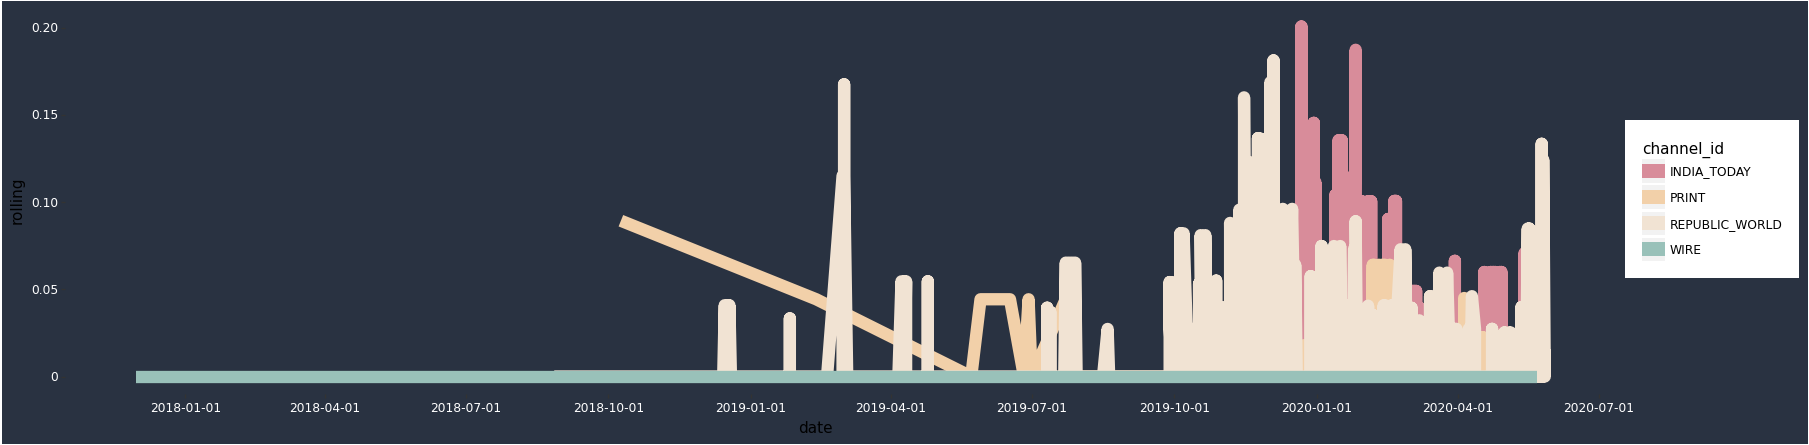

<ggplot: (-9223363282138575735)>


In [177]:
termByDate("army" , word_by_date)

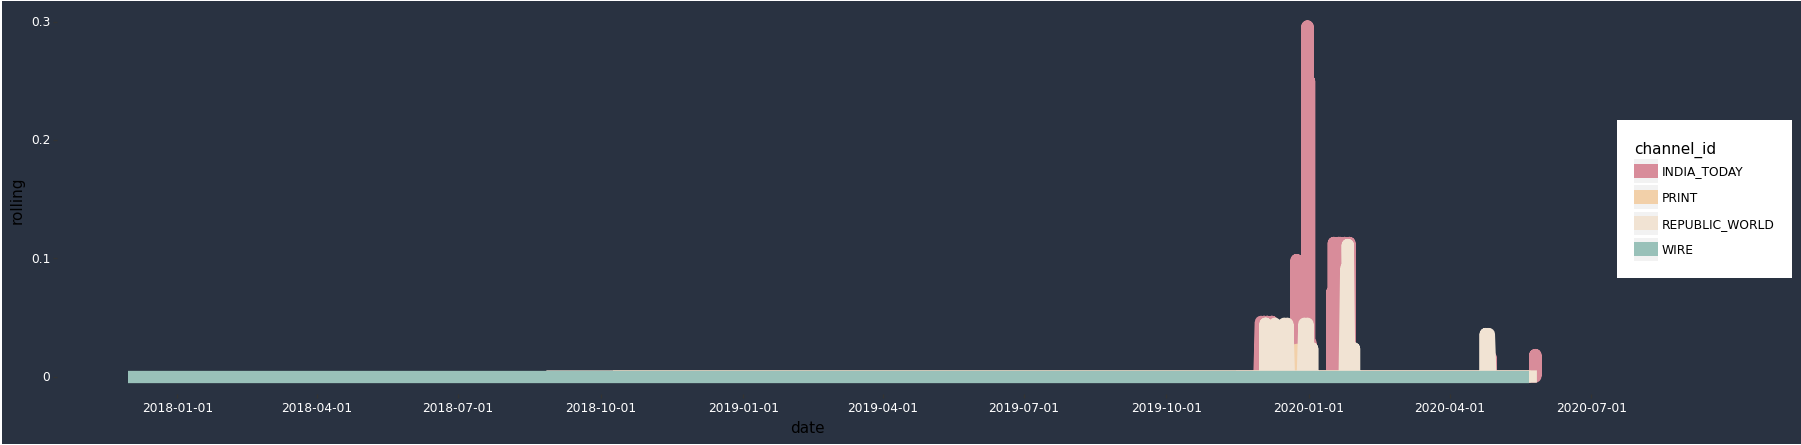

<ggplot: (-9223363282138614072)>


In [178]:
# Chief of defence staff
termByDate("cds" , word_by_date)

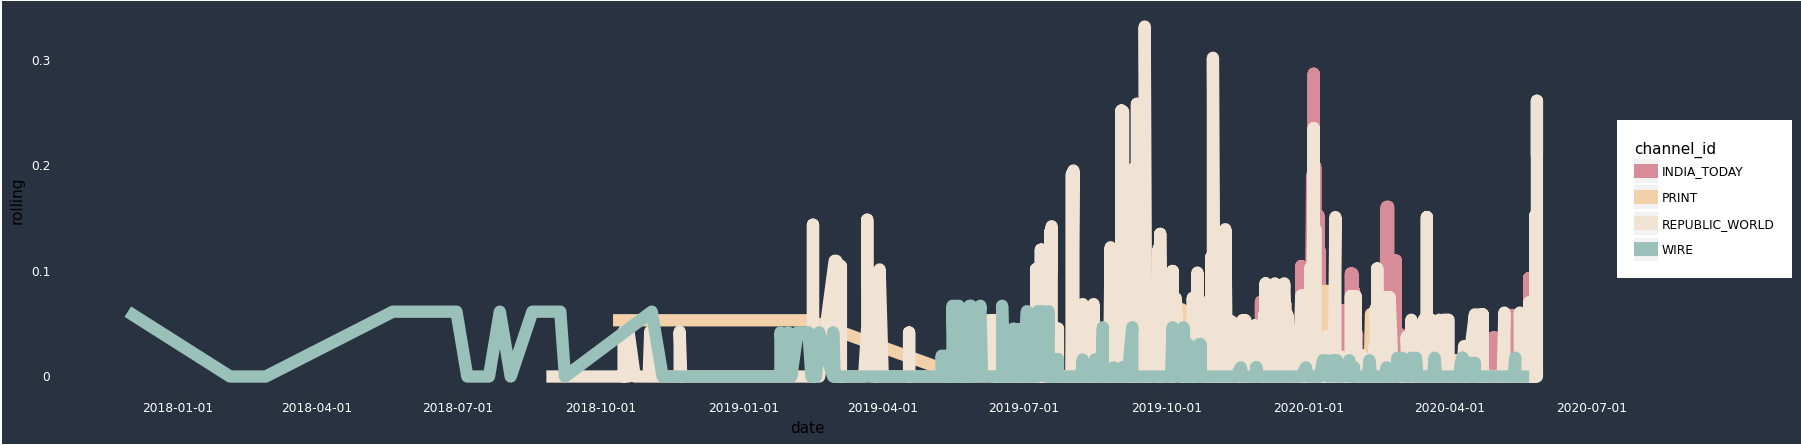

<ggplot: (-9223363282138455948)>


In [179]:
termByDate("pakistan" , word_by_date)

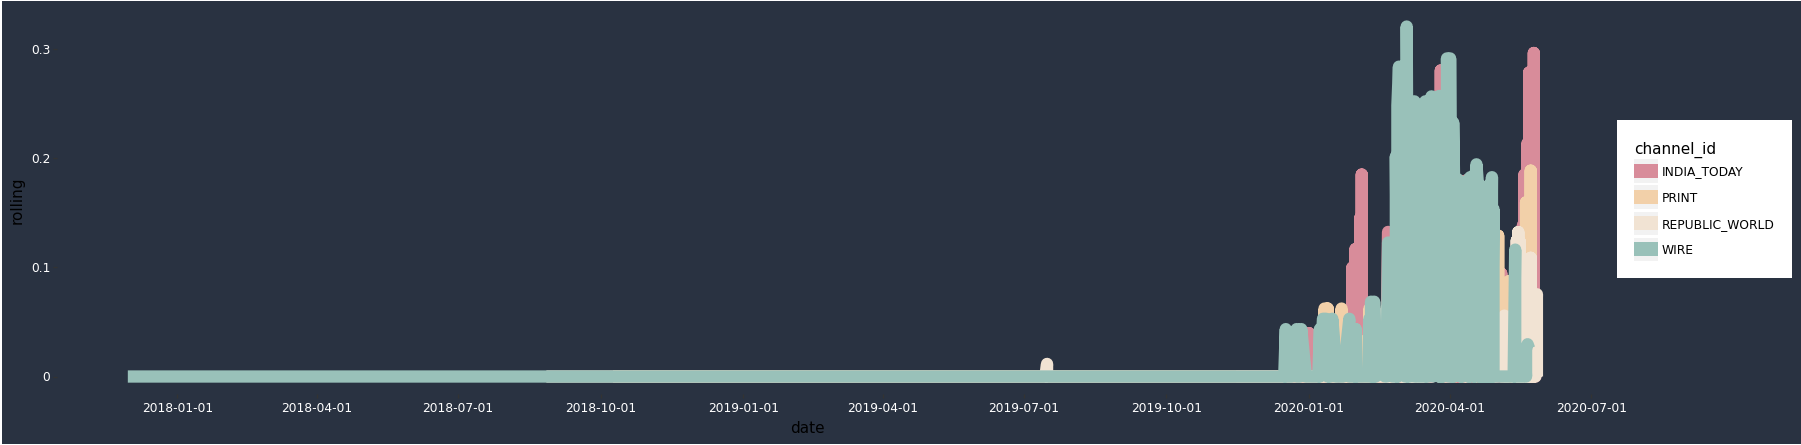

<ggplot: (-9223363282138574483)>


In [180]:
termByDate("coronavirus" , word_by_date)

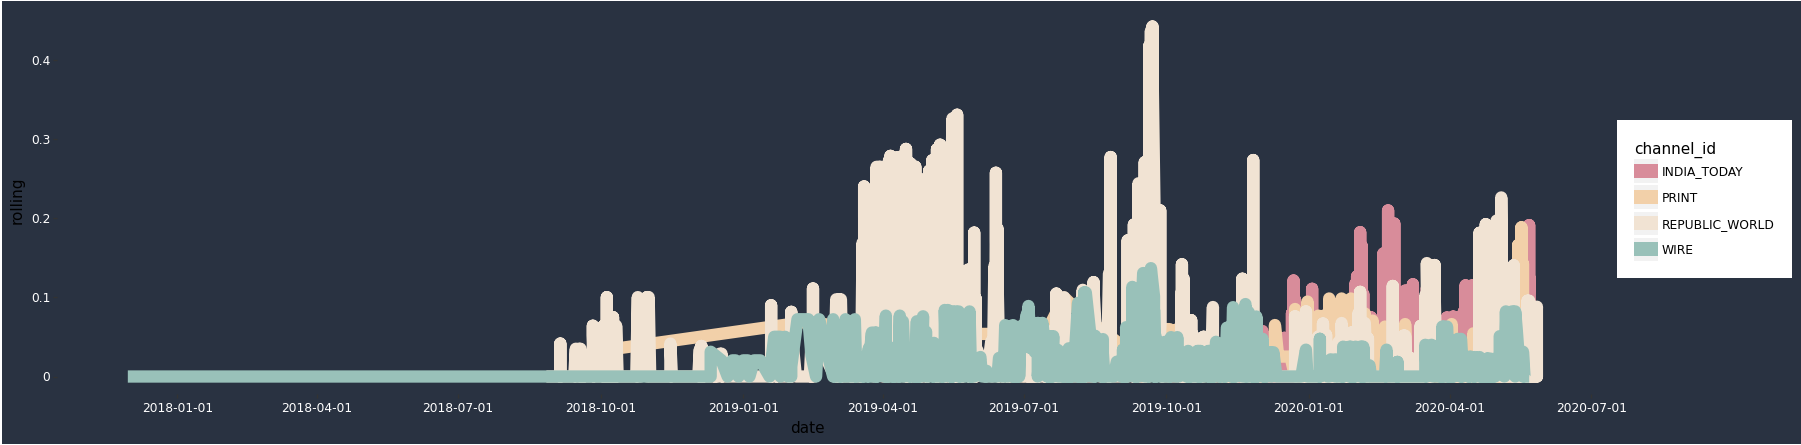

<ggplot: (-9223363282138877310)>


In [182]:
termByDate("modi" , word_by_date)

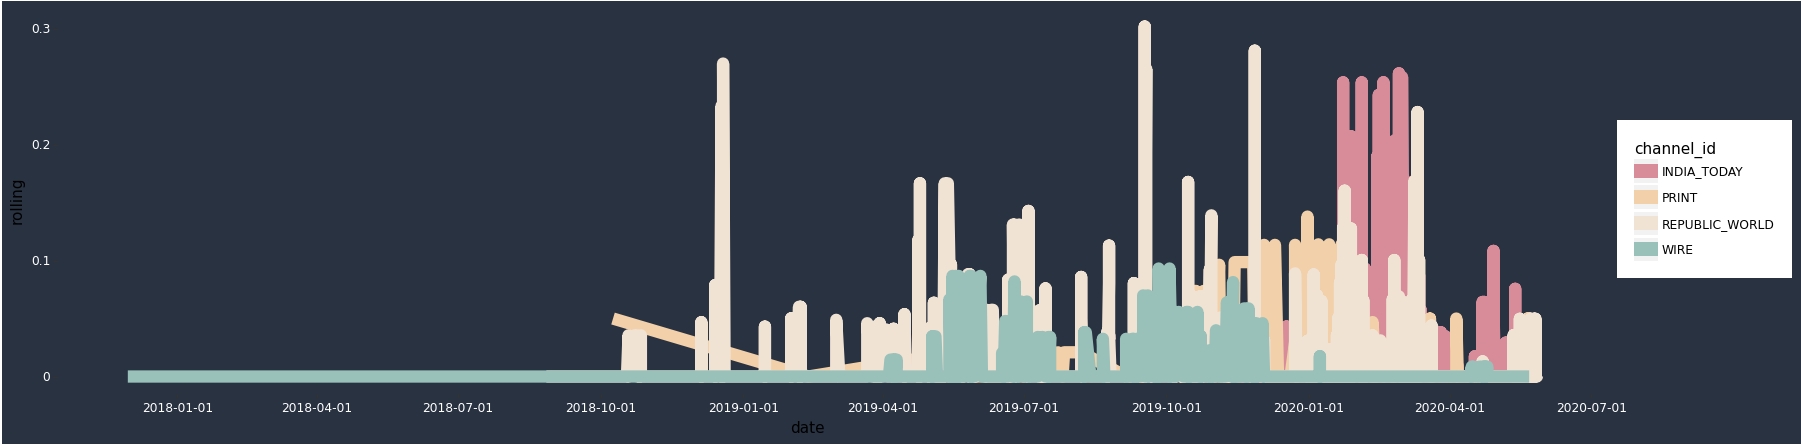

<ggplot: (8754715913385)>


In [183]:
termByDate("shah" , word_by_date)

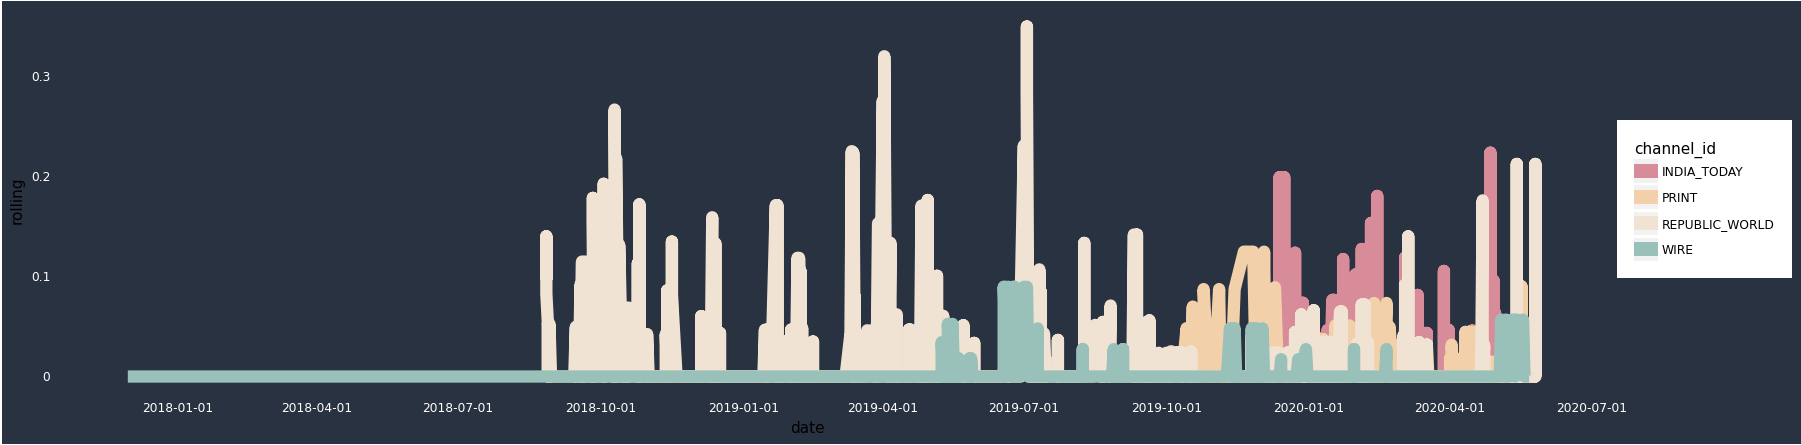

<ggplot: (-9223363282138920665)>


In [185]:
termByDate("rahul" , word_by_date)

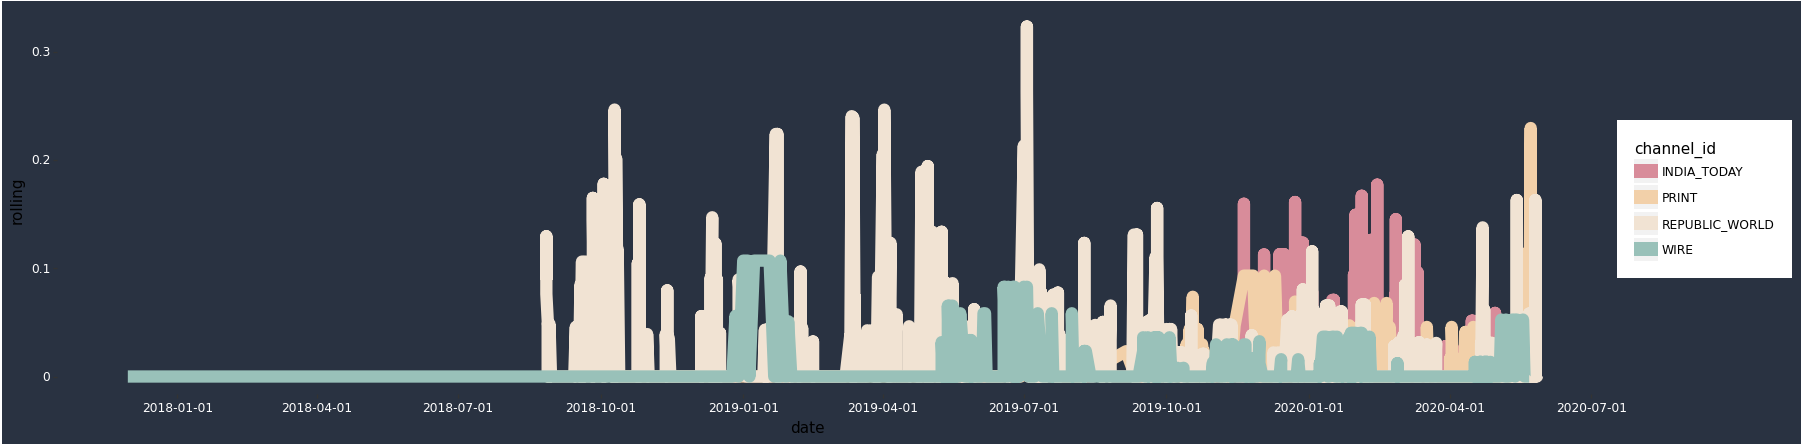

<ggplot: (8754715682340)>


In [187]:
# Should have similar trend as above
termByDate("gandhi" , word_by_date)

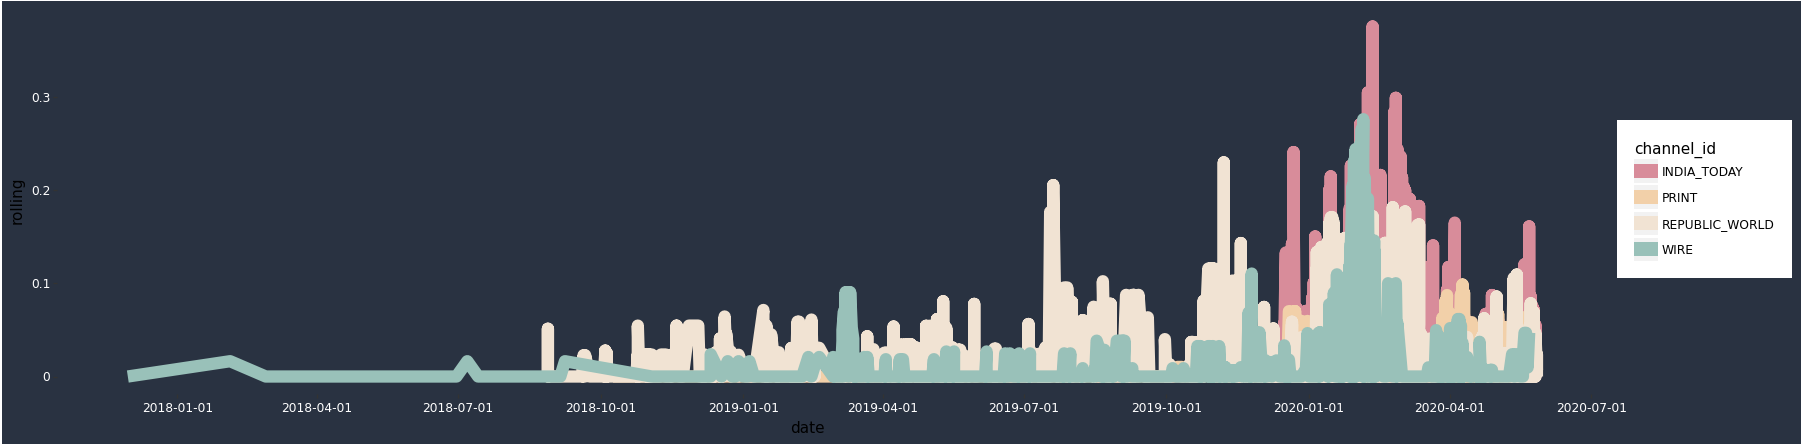

<ggplot: (8754715661446)>


In [190]:
termByDate("delhi" , word_by_date)

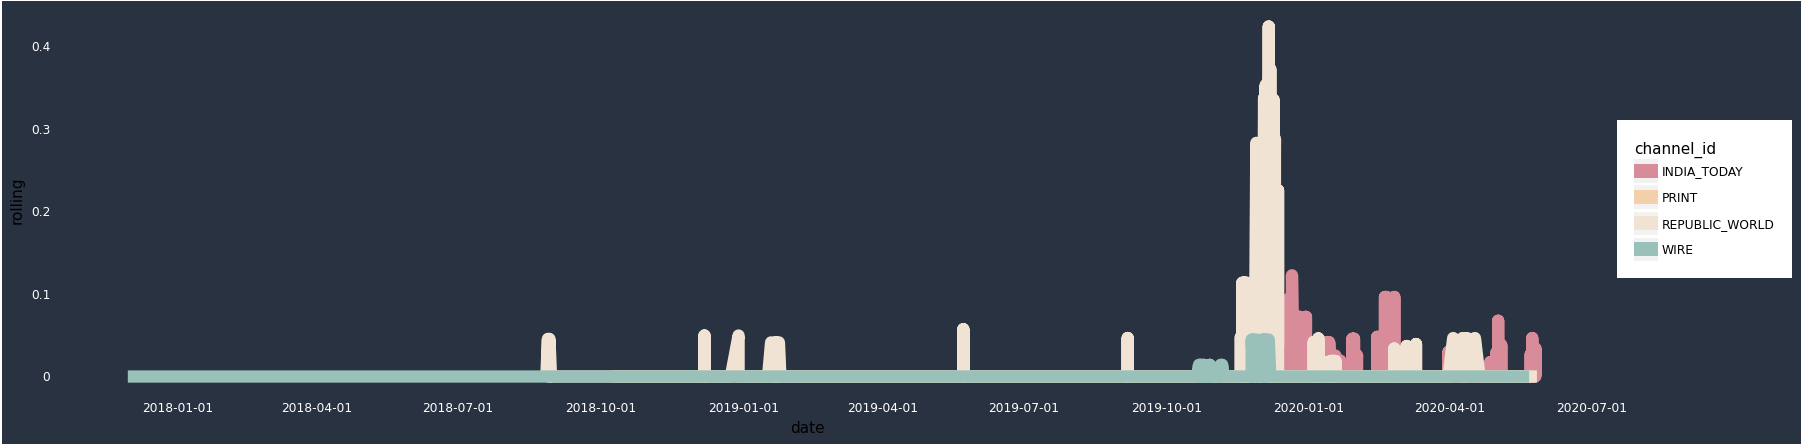

<ggplot: (-9223363282139085266)>


In [192]:
termByDate("hyderabad" , word_by_date)

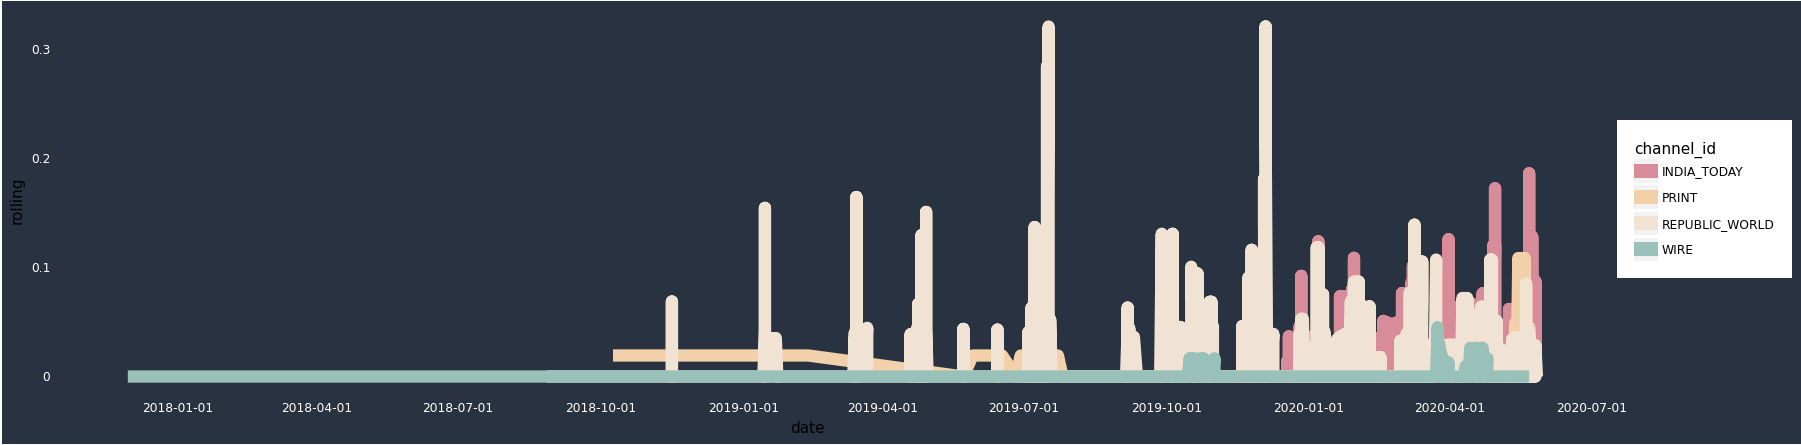

<ggplot: (-9223363282138991770)>


In [194]:
termByDate("mumbai" , word_by_date)

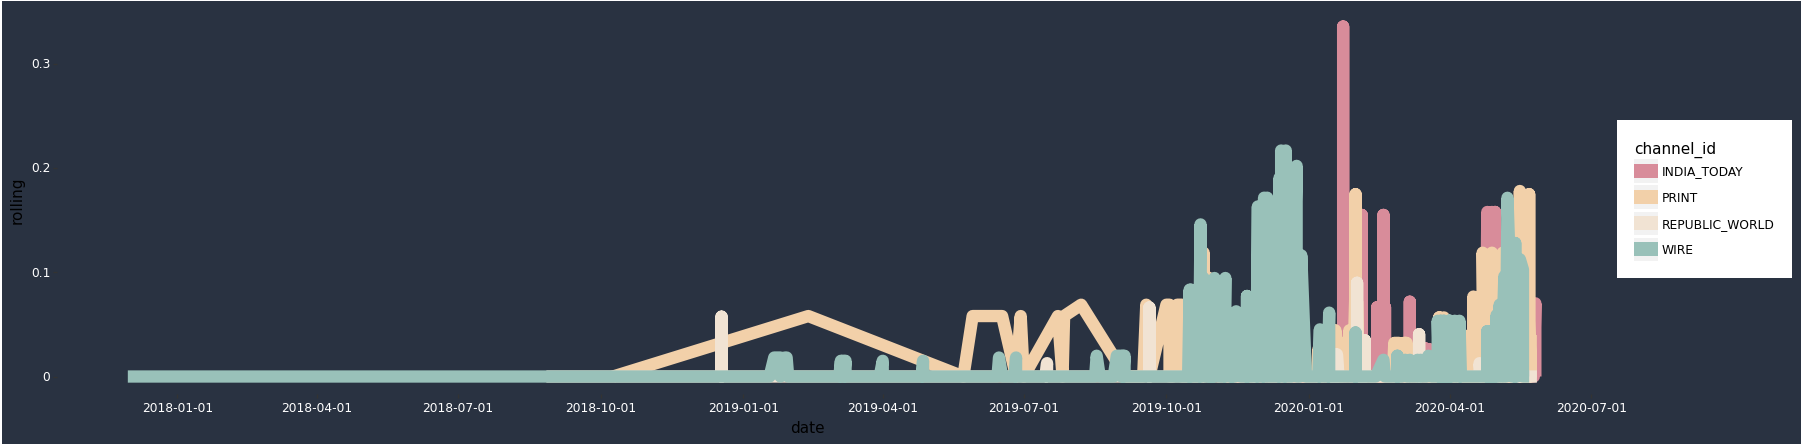

<ggplot: (-9223363282139244039)>


In [195]:
termByDate("economy" , word_by_date)

* NOTE - Note how suddenly republic drops, does nto seem to be talking about the ecomomy

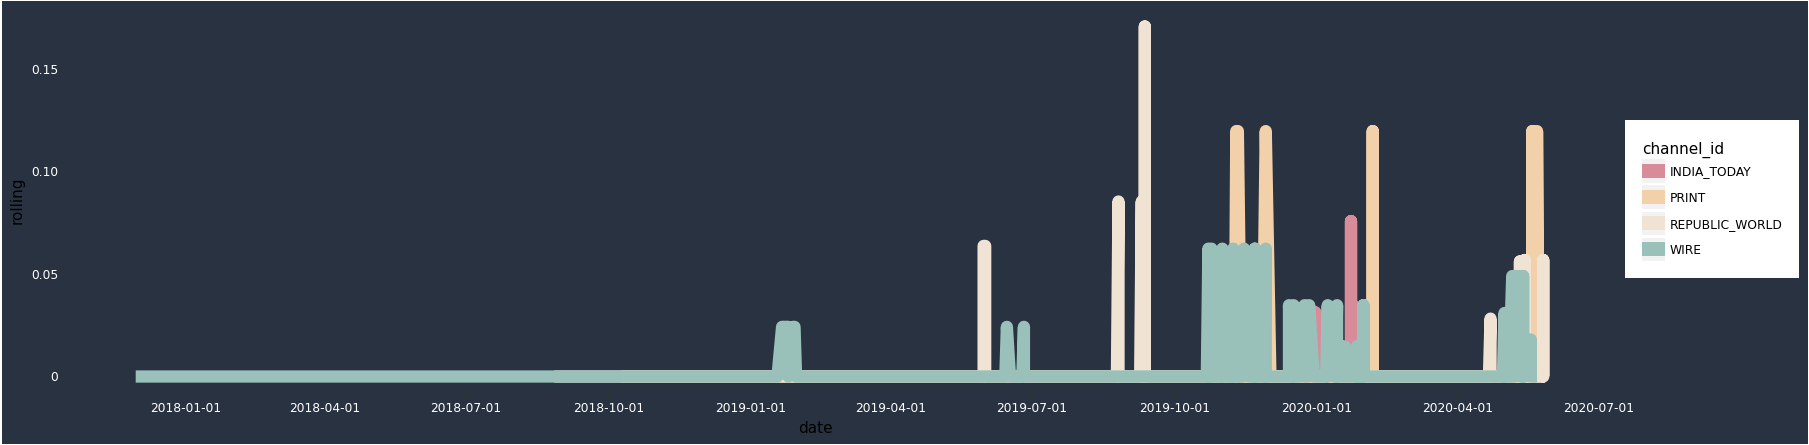

<ggplot: (-9223363282139875093)>


In [218]:
termByDate("gdp" , word_by_date)

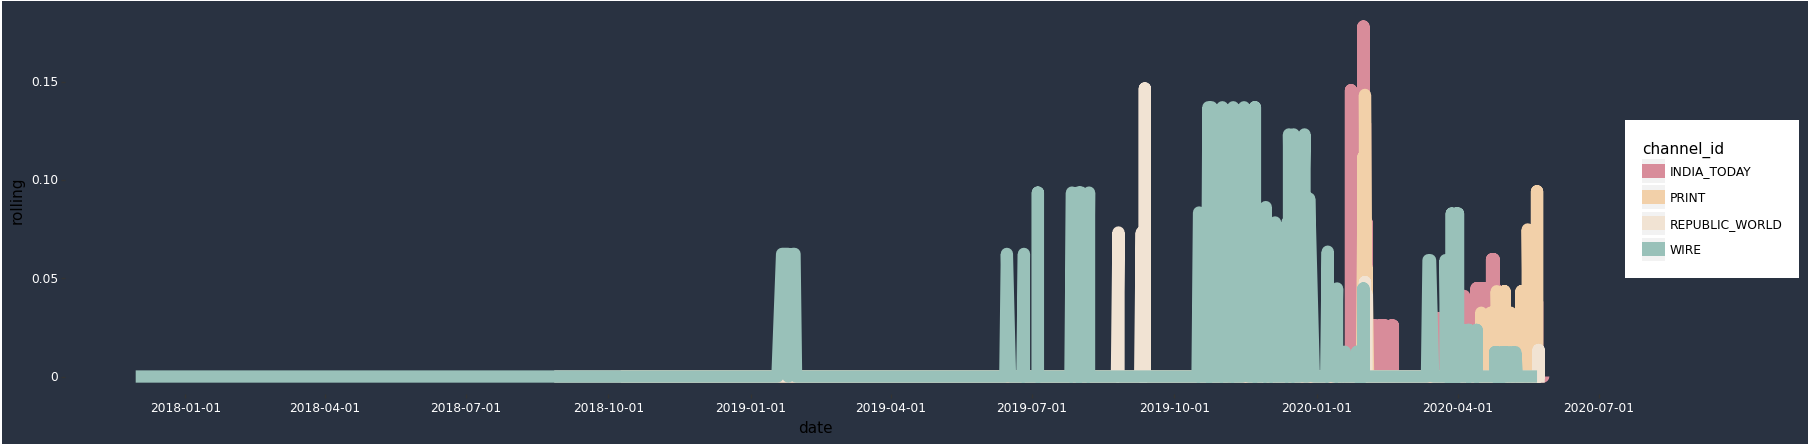

<ggplot: (-9223363282139734440)>


In [219]:
termByDate("growth" , word_by_date)

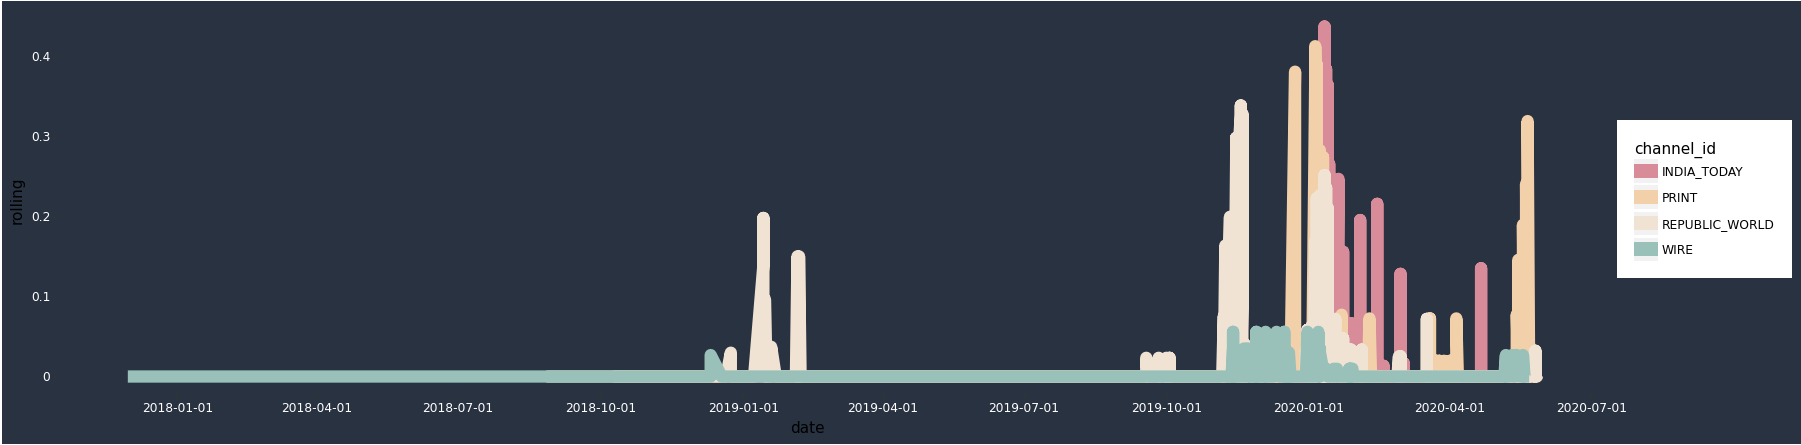

<ggplot: (8754715087736)>


In [213]:
termByDate("jnu" , word_by_date)

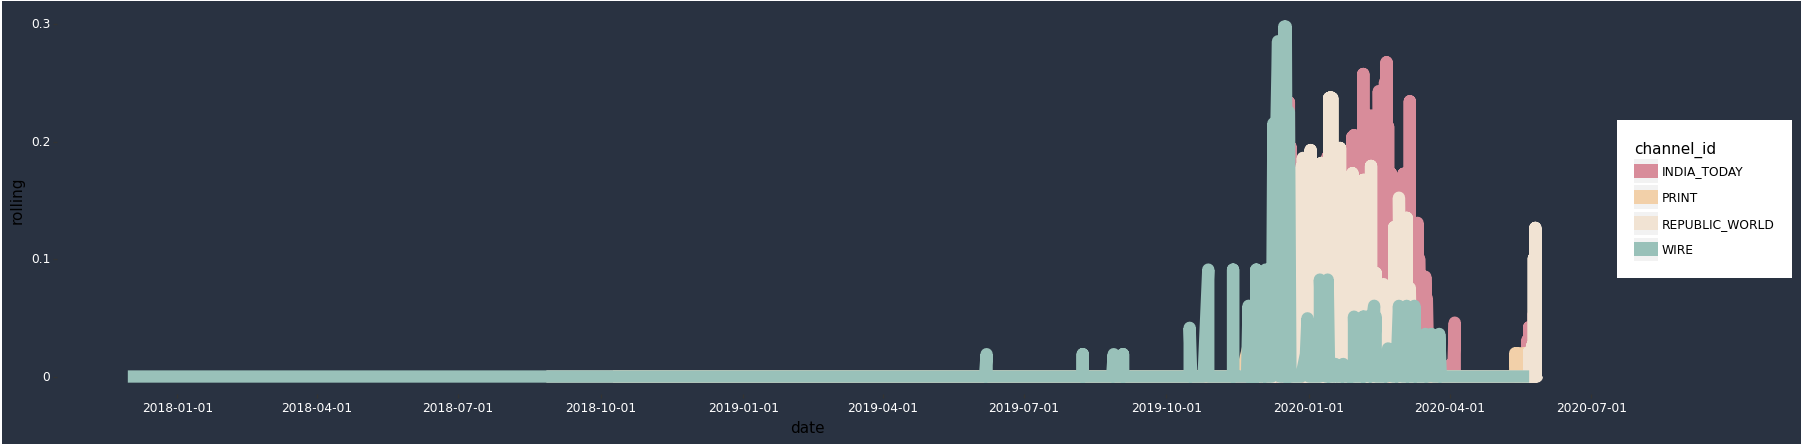

<ggplot: (-9223363282139342553)>


In [198]:
termByDate("caa" , word_by_date)

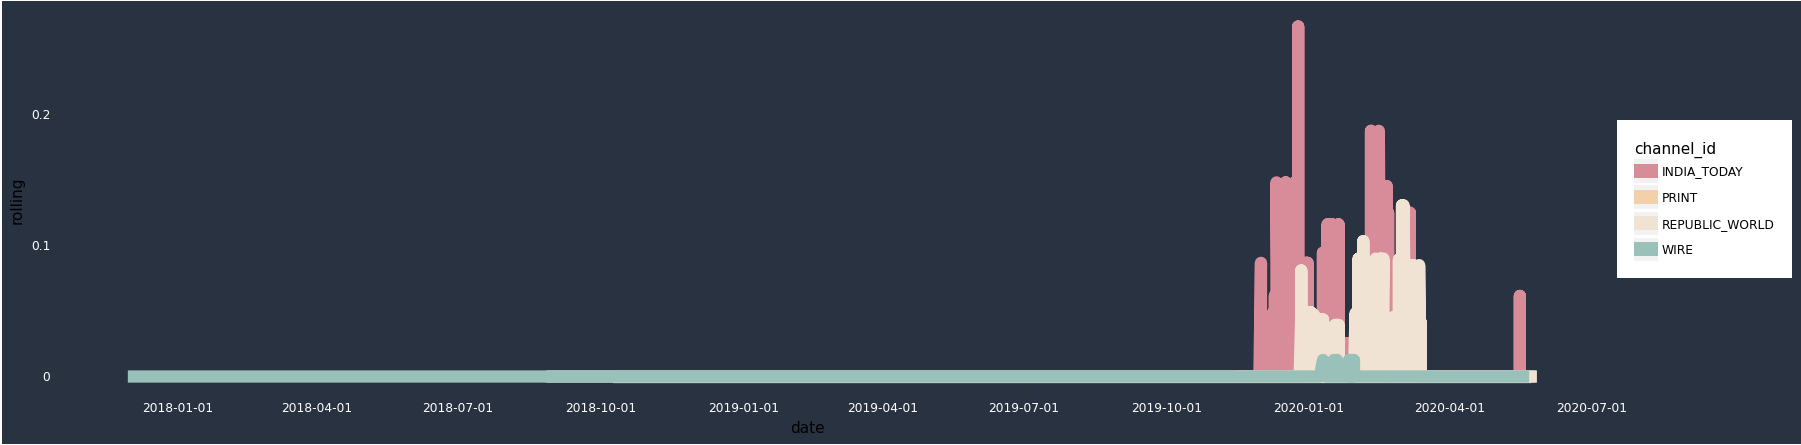

<ggplot: (-9223363282138318150)>


In [199]:
termByDate("npr" , word_by_date)

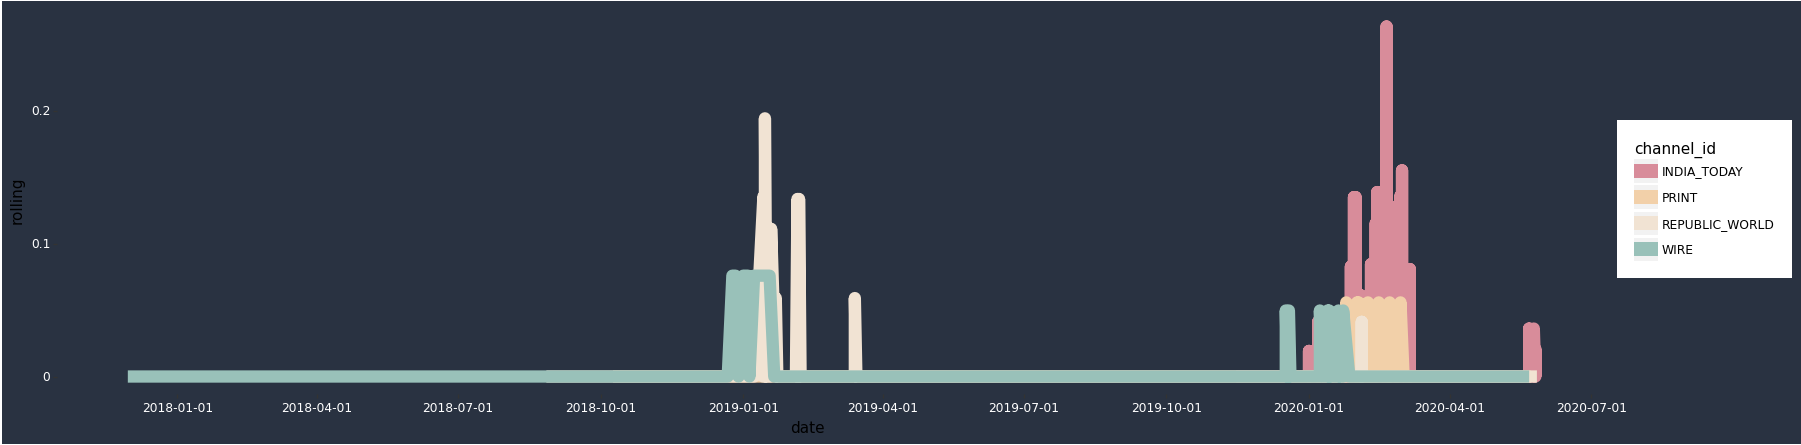

<ggplot: (8754716457676)>


In [200]:
termByDate("sedition" , word_by_date)

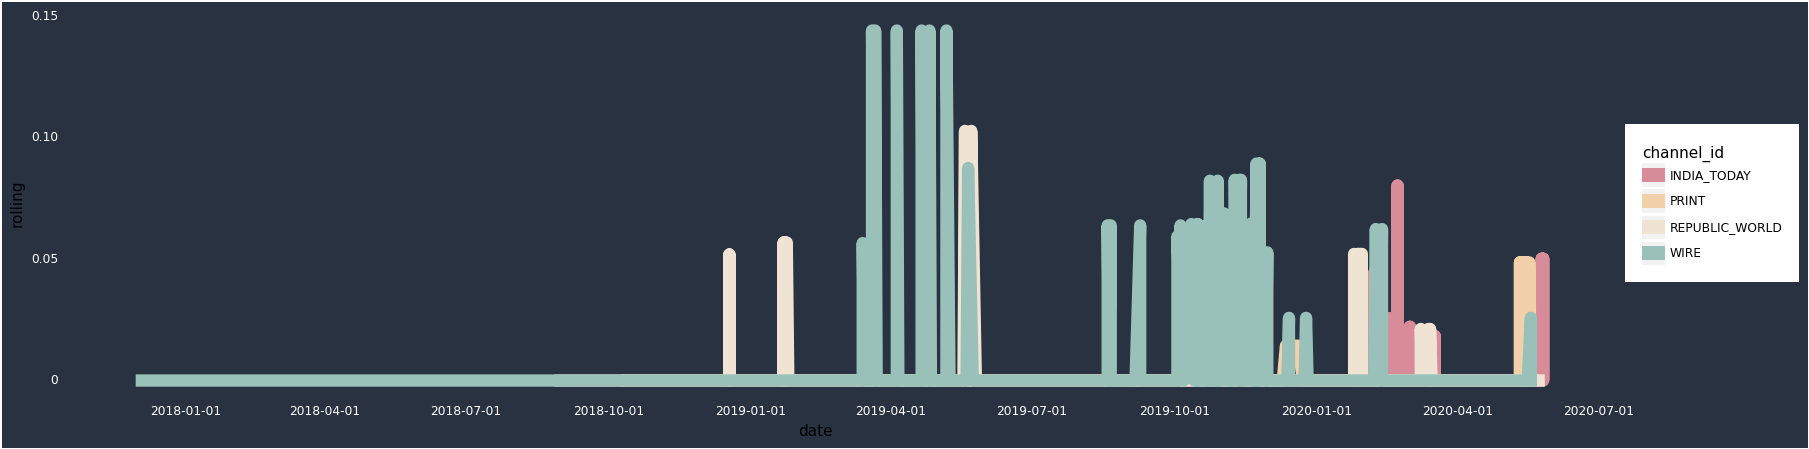

<ggplot: (8754715347548)>


In [202]:
termByDate("democracy" , word_by_date)

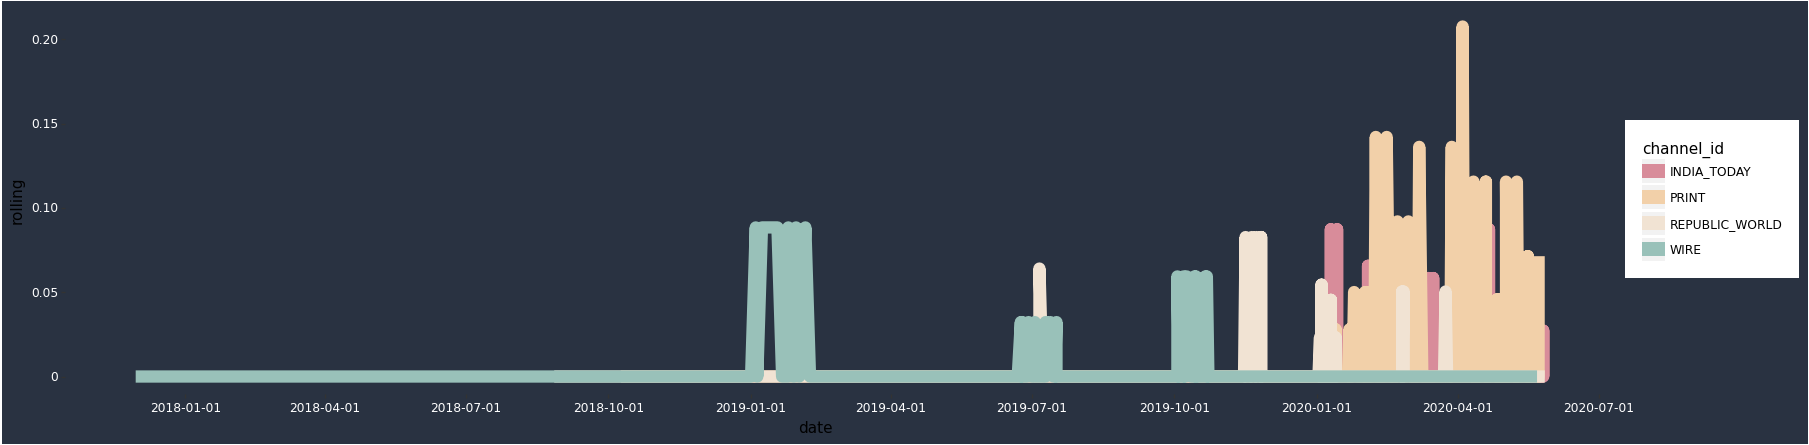

<ggplot: (8754715349203)>


In [203]:
termByDate("freedom" , word_by_date)

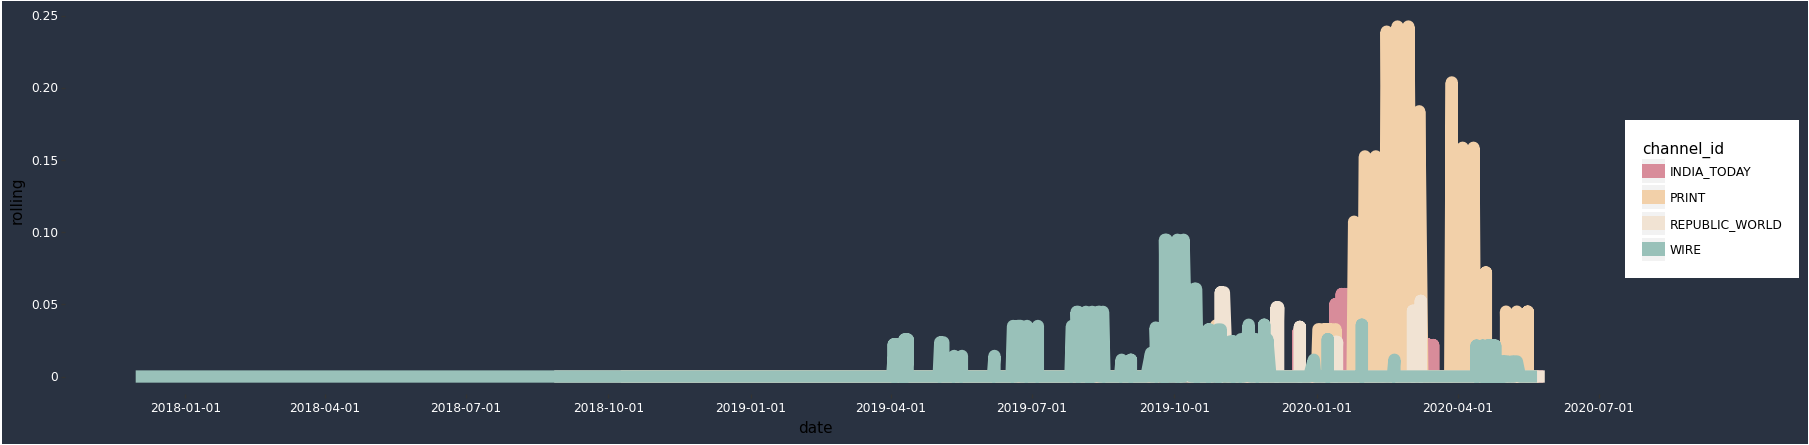

<ggplot: (8754715635944)>


In [205]:
termByDate("rights" , word_by_date)

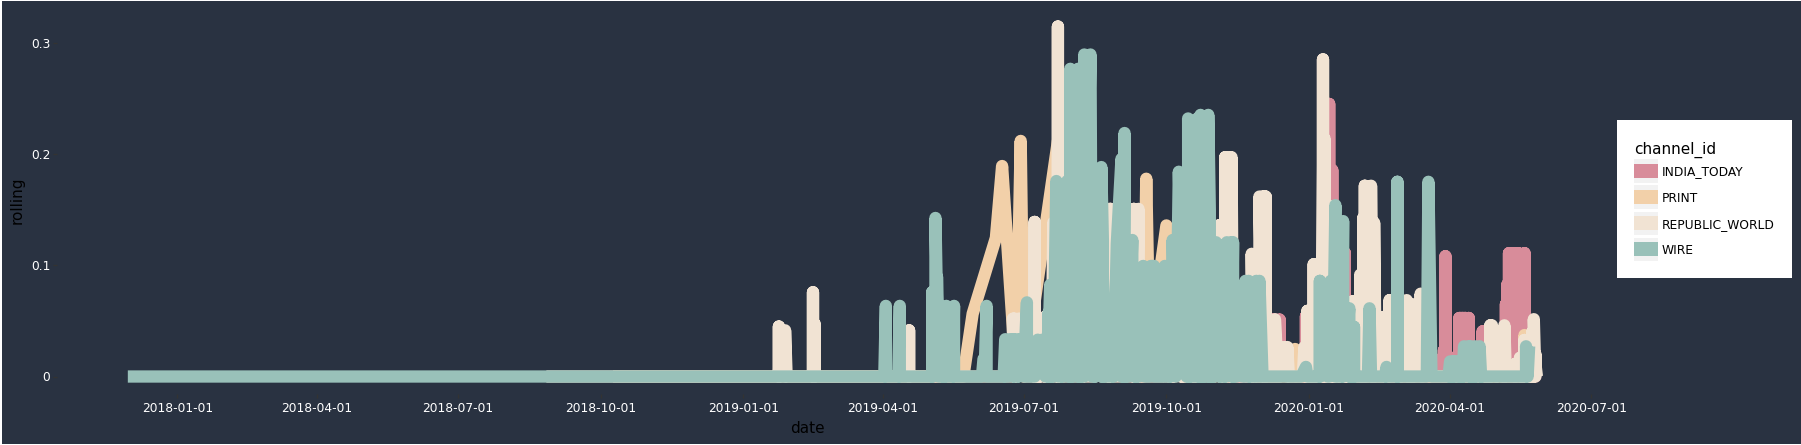

<ggplot: (8754715213425)>


In [206]:
termByDate("kashmir" , word_by_date)

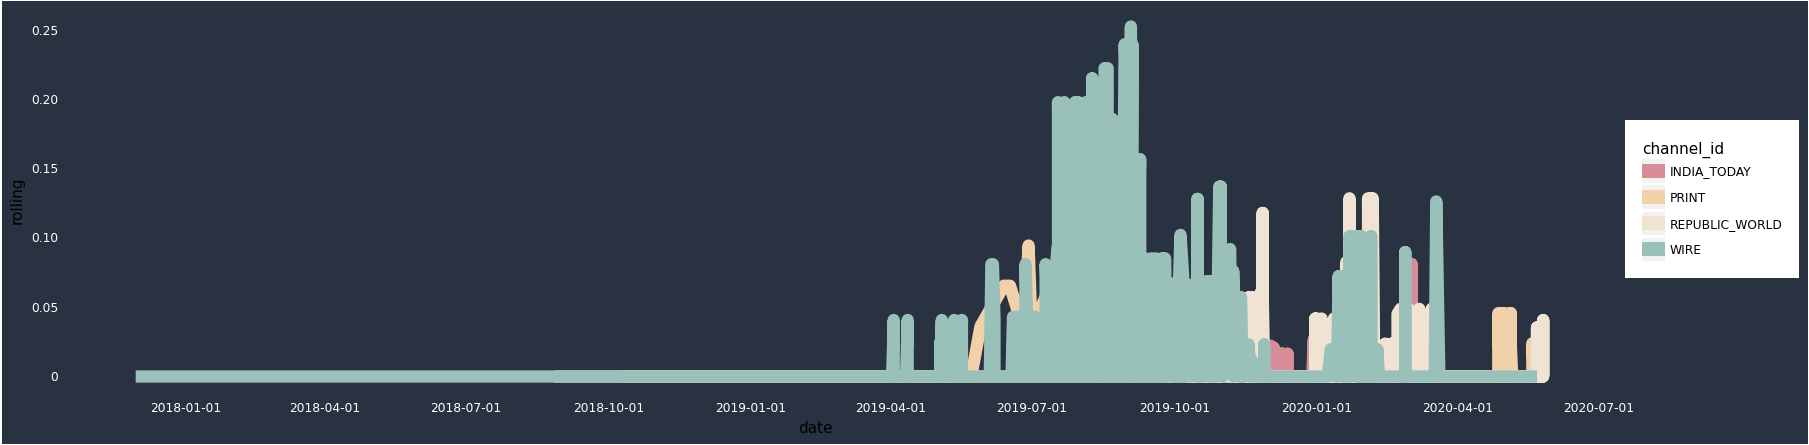

<ggplot: (8754715161457)>


In [207]:
termByDate("370" , word_by_date)

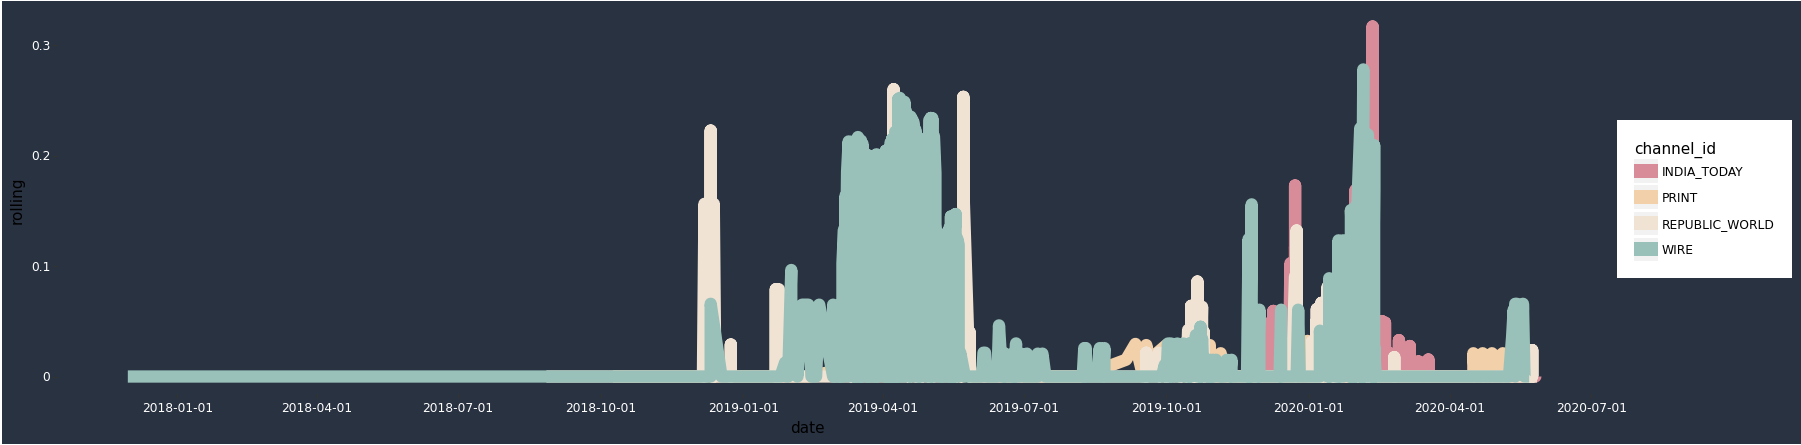

<ggplot: (-9223363282139517685)>


In [215]:
termByDate("election" , word_by_date)

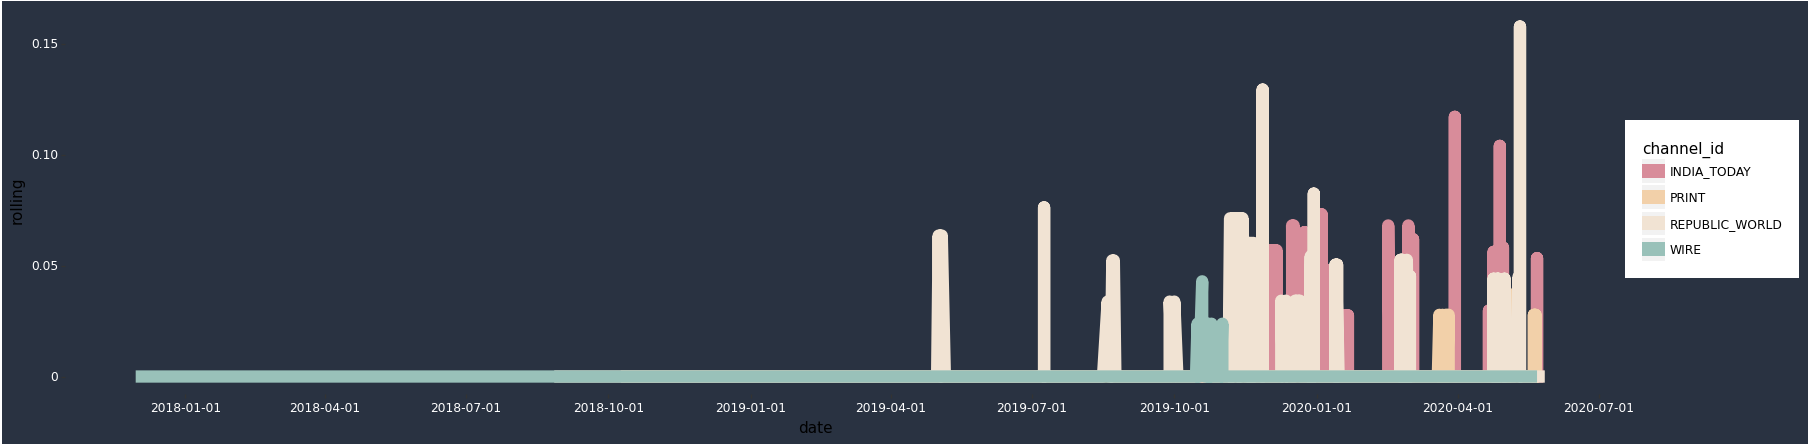

<ggplot: (-9223363282139458588)>


In [216]:
termByDate("fake" , word_by_date)

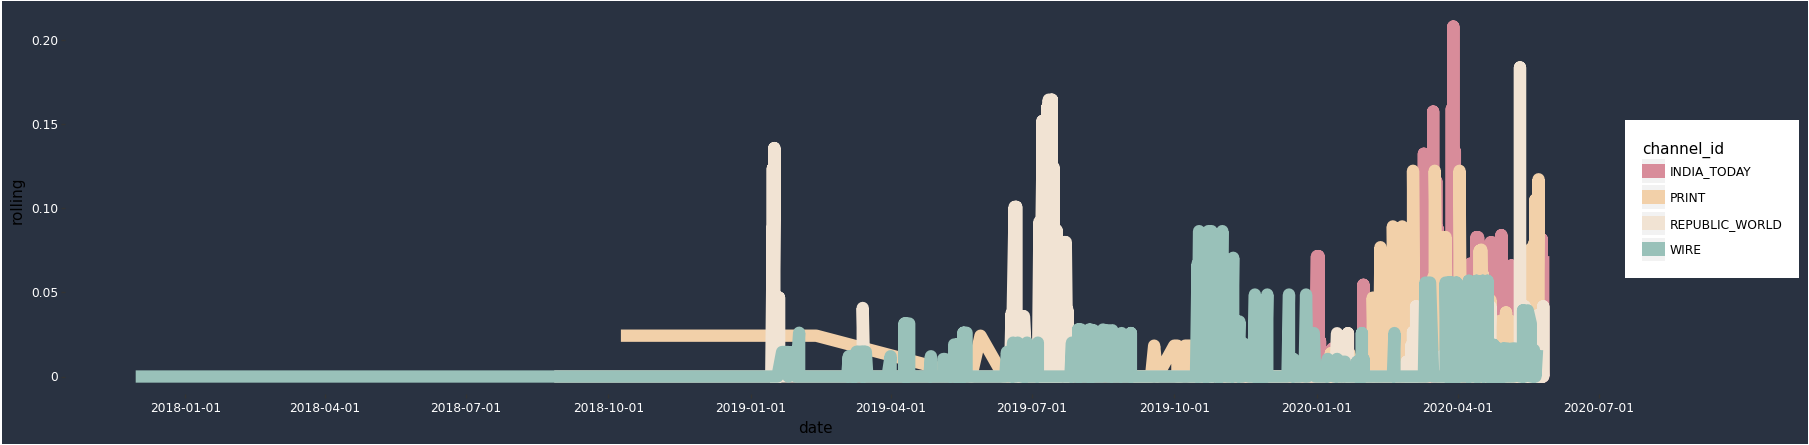

<ggplot: (8754714995839)>


In [220]:
termByDate("crisis" , word_by_date)

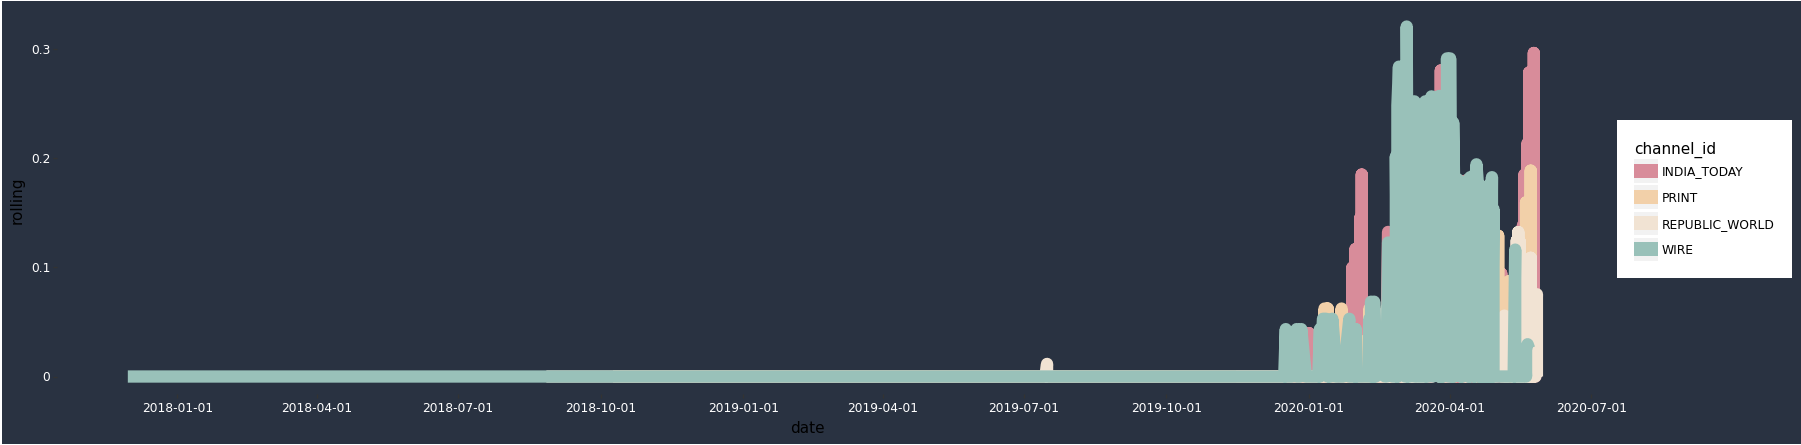

<ggplot: (8754715049273)>


In [221]:
termByDate("coronavirus" , word_by_date)

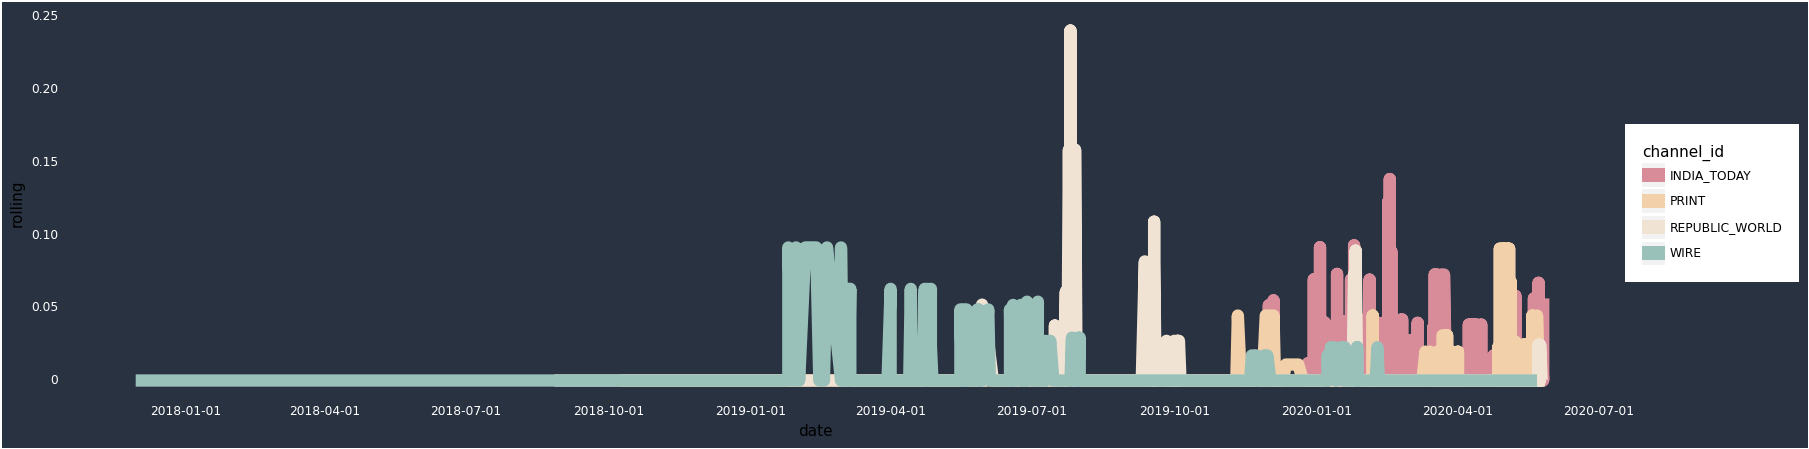

<ggplot: (-9223363282139830384)>


In [222]:
termByDate("war" , word_by_date)

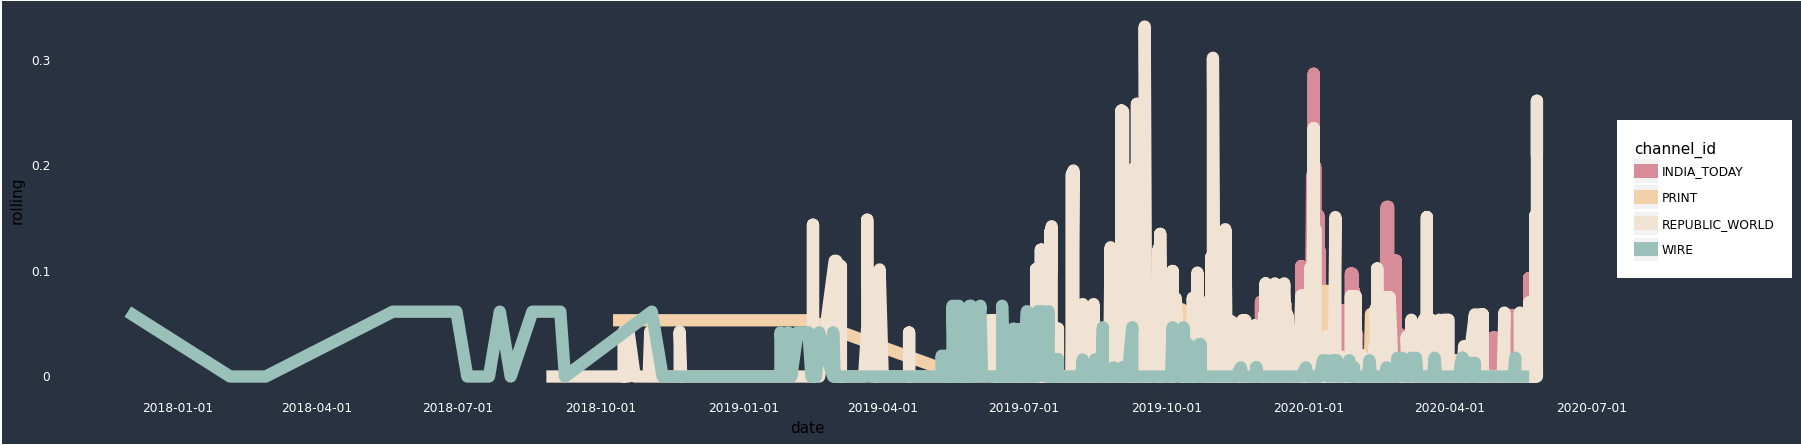

<ggplot: (-9223363282139830356)>


In [223]:
termByDate("pakistan" , word_by_date)

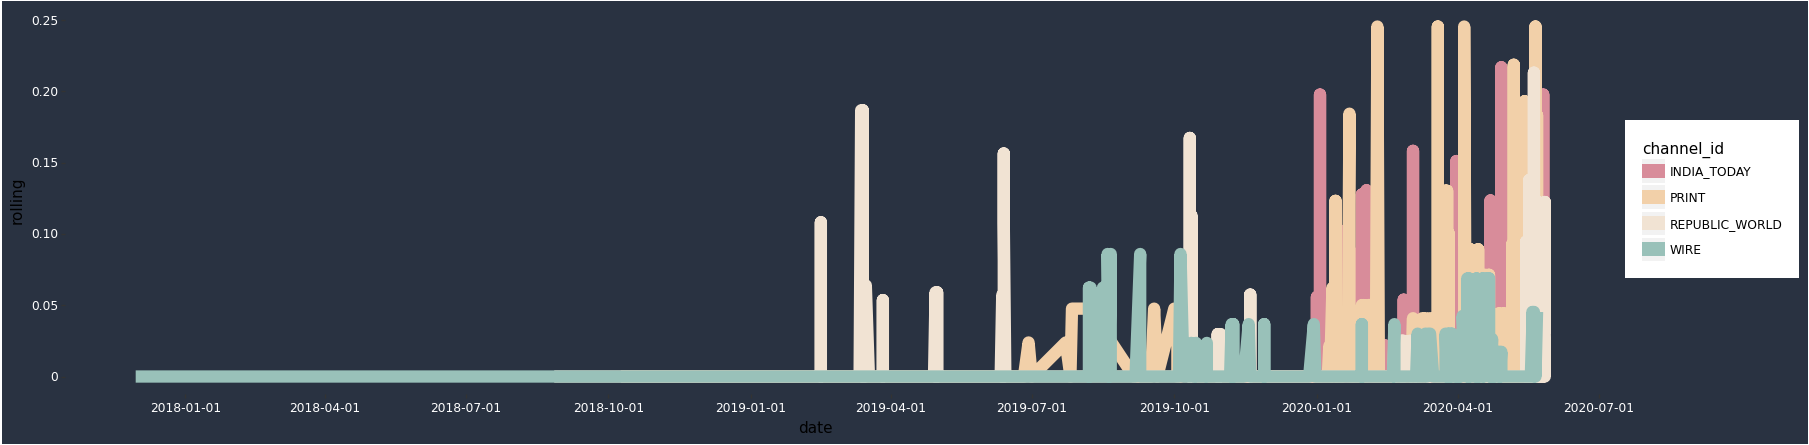

<ggplot: (8754714809934)>


In [224]:
termByDate("china" , word_by_date)

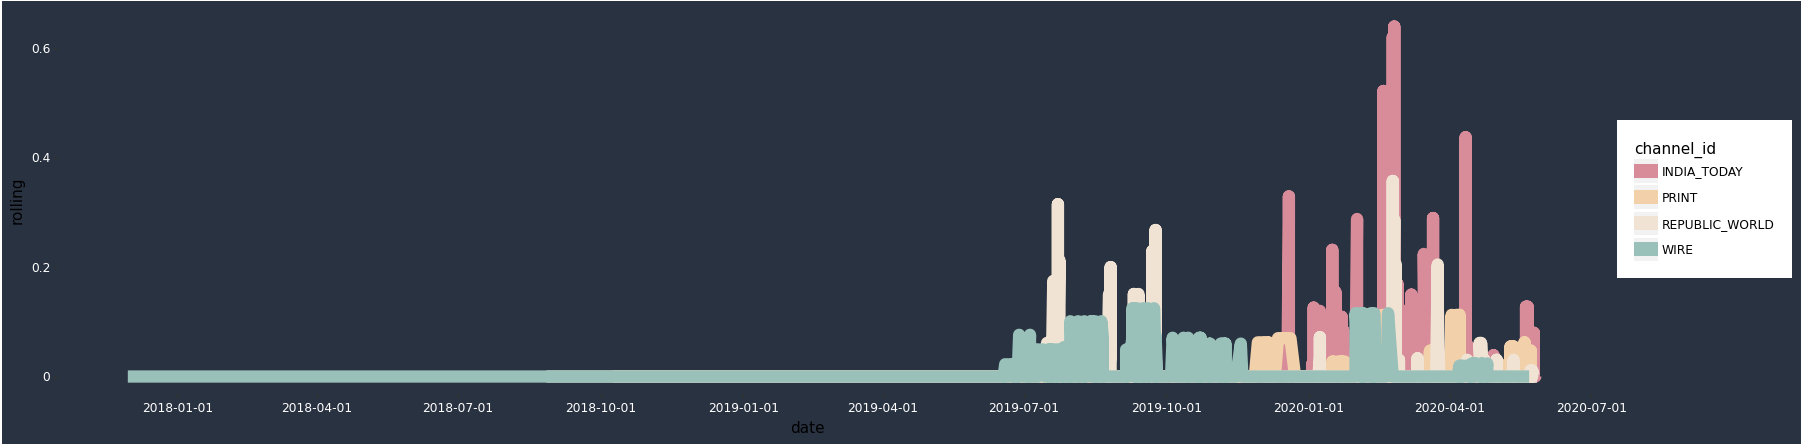

<ggplot: (-9223363282140078946)>


In [227]:
termByDate("trump" , word_by_date)

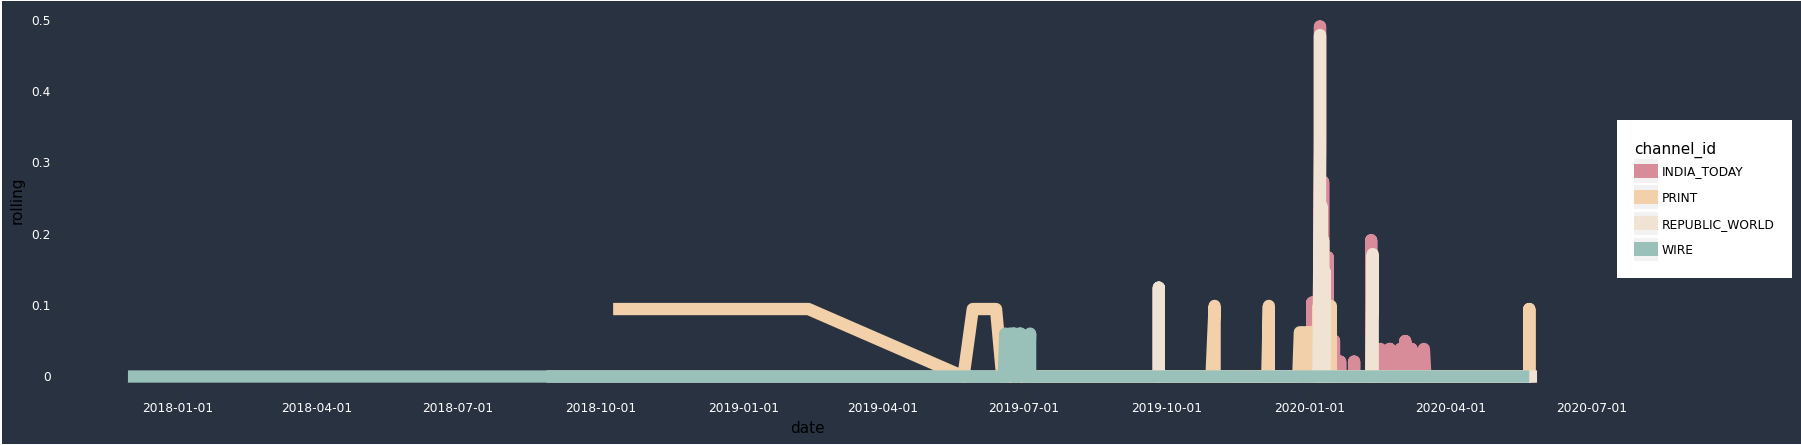

<ggplot: (8754714696761)>


In [231]:
termByDate("iran" , word_by_date)

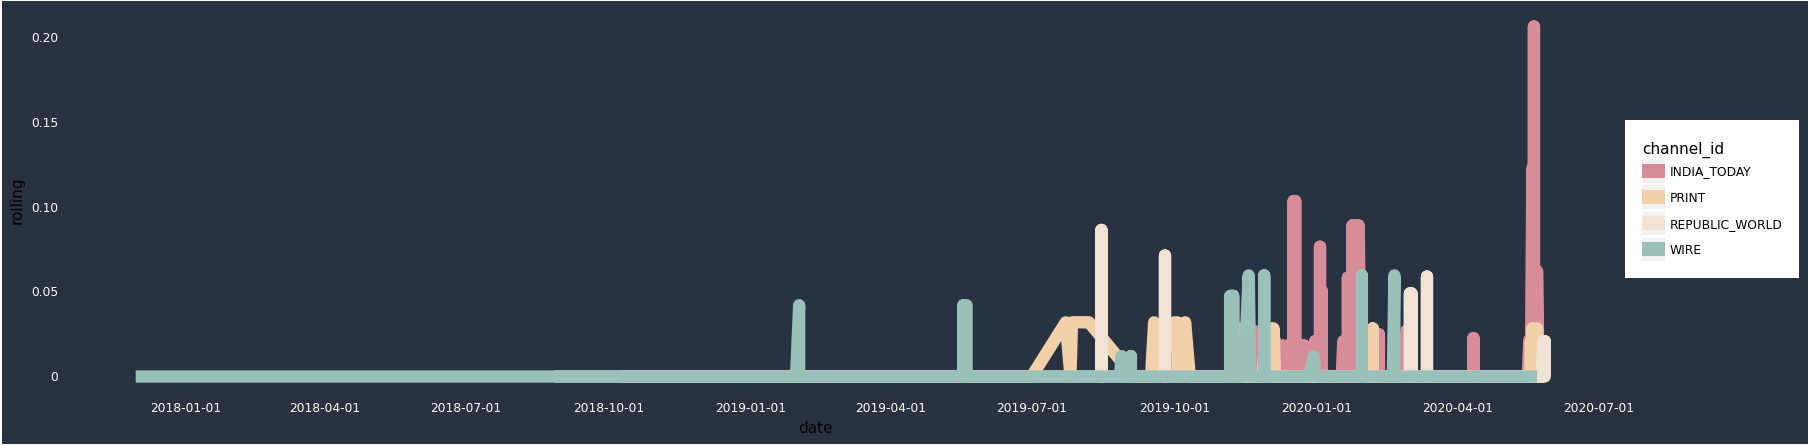

<ggplot: (-9223363282140268989)>


In [236]:
termByDate("bangladesh" , word_by_date)

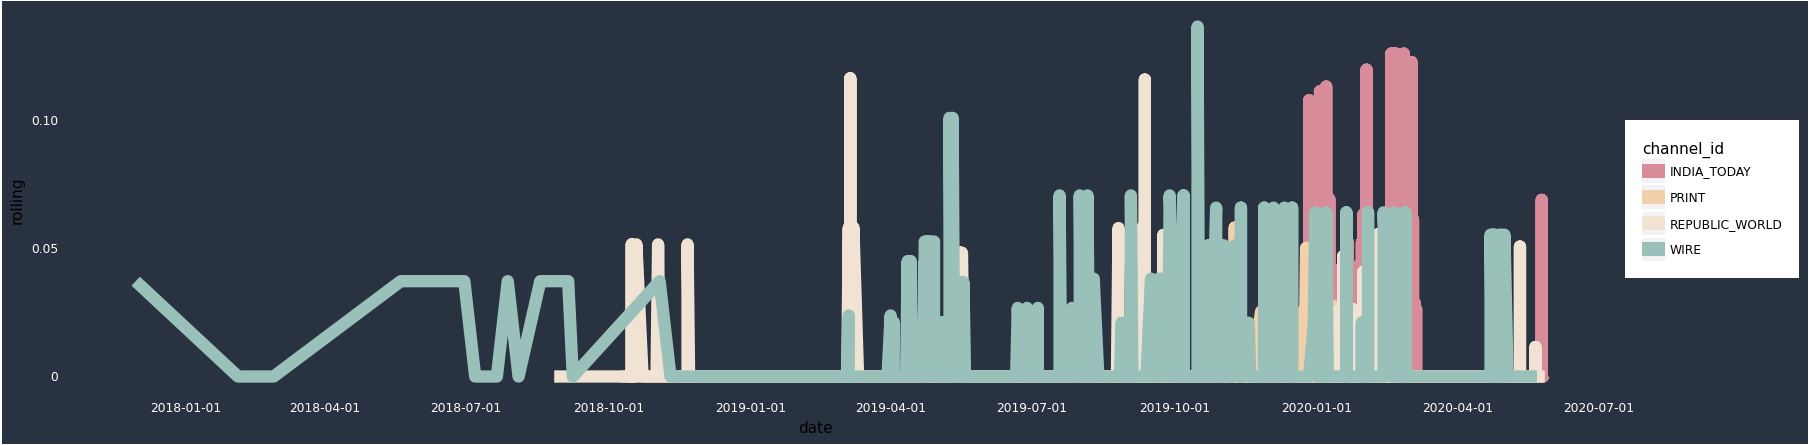

<ggplot: (8754714455837)>


In [240]:
termByDate("hindu" , word_by_date)

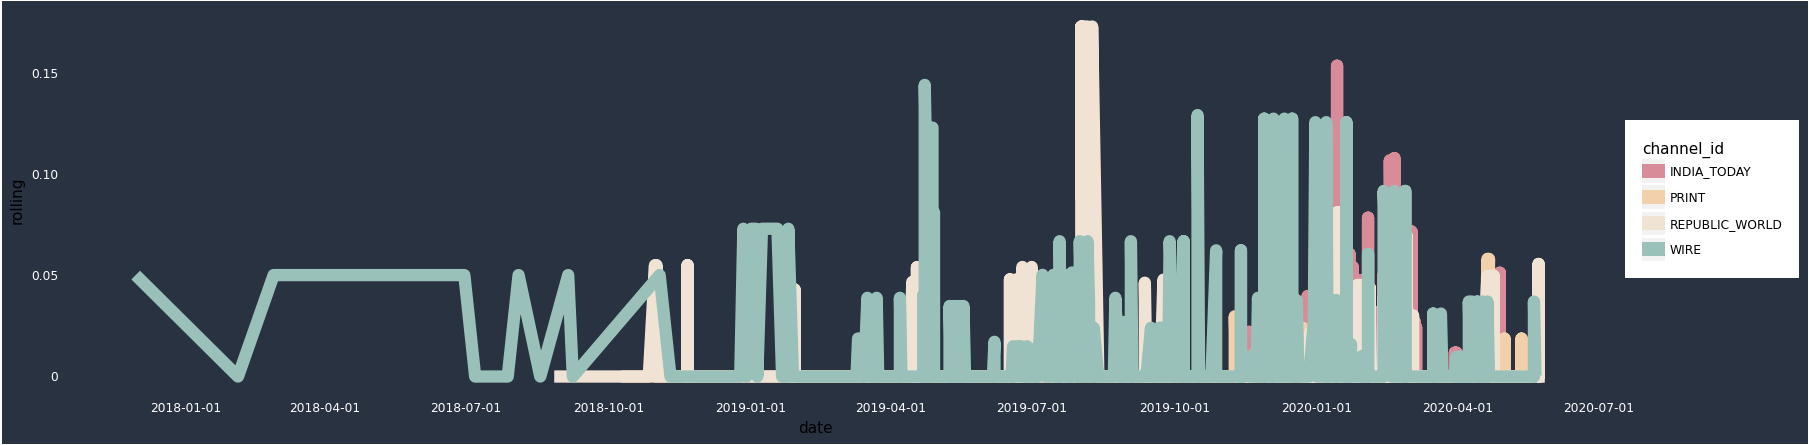

<ggplot: (-9223363282140136858)>


In [241]:
termByDate("muslim" , word_by_date)

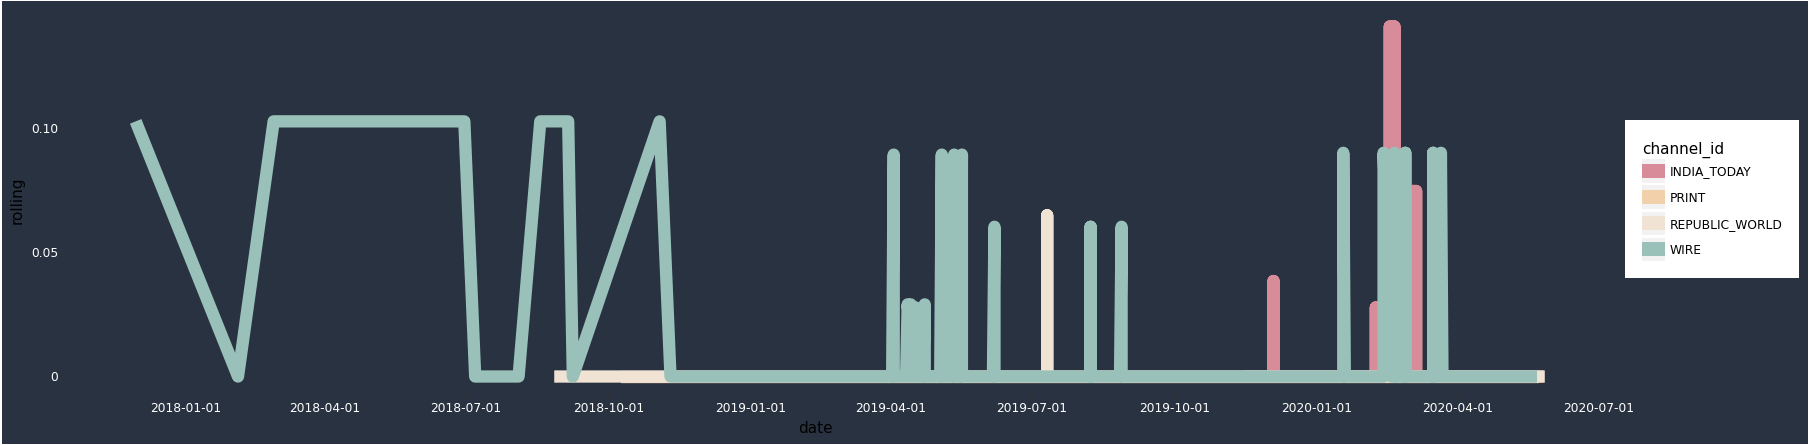

<ggplot: (-9223363282140268449)>


In [242]:
termByDate("dalit" , word_by_date)